In [ ]:
 #install yolov8
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


In [ ]:
#unzip if roboflow not working
!unzip "/content/drive/MyDrive/Computational imaging/Leaf area.v5i.yolov5pytorch.zip" -d /content/

Archive:  /content/drive/MyDrive/Computational imaging/Leaf area.v5i.yolov5pytorch.zip
 extracting: /content/README.roboflow.txt  
 extracting: /content/data.yaml      
   creating: /content/test/
   creating: /content/test/images/
 extracting: /content/test/images/AMF001_jpg.rf.d622260e86198ae7996b76db4b358842.jpg  
 extracting: /content/test/images/AMF007_jpg.rf.52c0e08b1b59196ce0971502d7ebd59c.jpg  
 extracting: /content/test/images/AMF038_jpg.rf.11fbd58541c887fff23fcd32a839e54f.jpg  
 extracting: /content/test/images/AMF043_jpg.rf.ce9b7b4eacce17148fcbbfc4684ffe97.jpg  
 extracting: /content/test/images/AMF051_jpg.rf.bf7ea85cc57b9ae82da7d84c1b313e56.jpg  
 extracting: /content/test/images/AMF055_jpg.rf.f7126d5de9d7529740b9a009fc2d091c.jpg  
 extracting: /content/test/images/AMF065_jpg.rf.bfd738cfc21d8558715dbdb773ab9e63.jpg  
 extracting: /content/test/images/AMF074_jpg.rf.cb3de3e5bf0b8ede57738b42222a1148.jpg  
 extracting: /content/test/images/AMF104_jpg.rf.7106a7bdb240331f638fb242

In [ ]:
#imports
import torch
from ultralytics import YOLO
#from roboflow import Roboflow

In [ ]:
#training on base model
#replace data.yaml path if necessary
#setting random seed to 42
model = YOLO("yolov8l-seg.pt")
results = model.train(data="/content/data.yaml", epochs=100, imgsz=640, seed = 42)



image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF007.jpg: 640x480 7 leafs, 145.1ms
Speed: 12.6ms preprocess, 145.1ms inference, 5170.6ms postprocess per image at shape (1, 3, 640, 480)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        



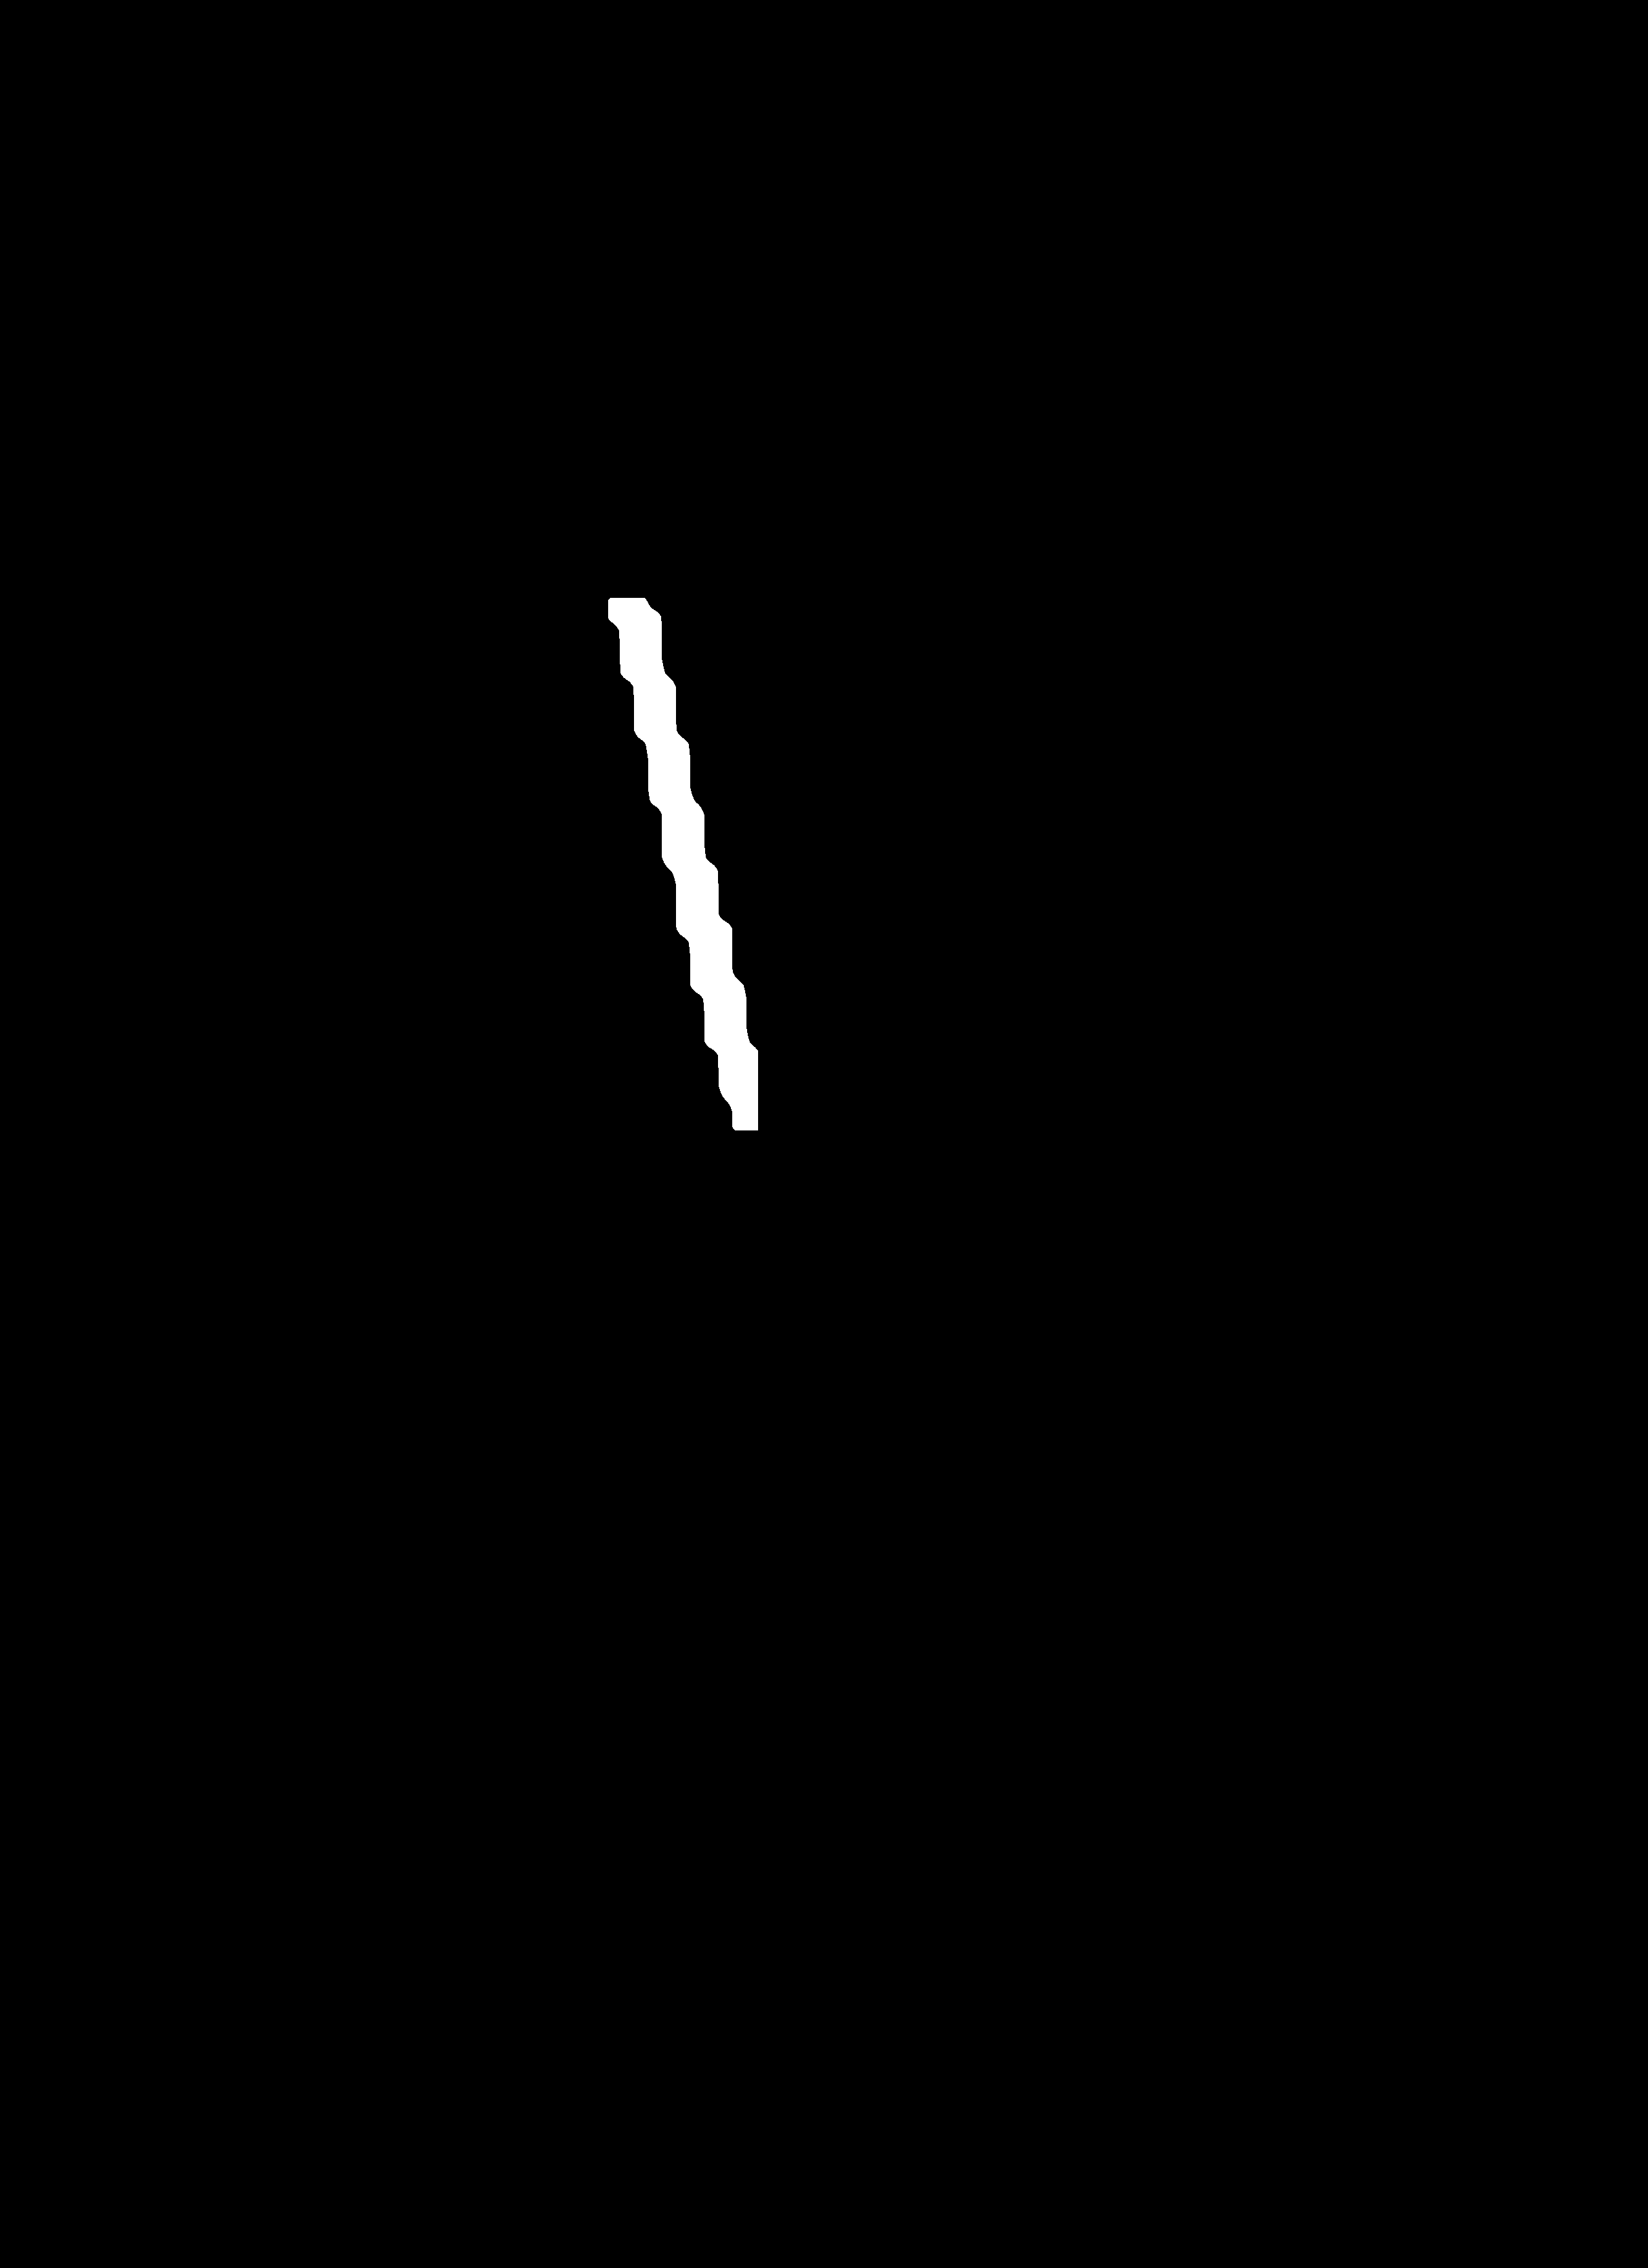
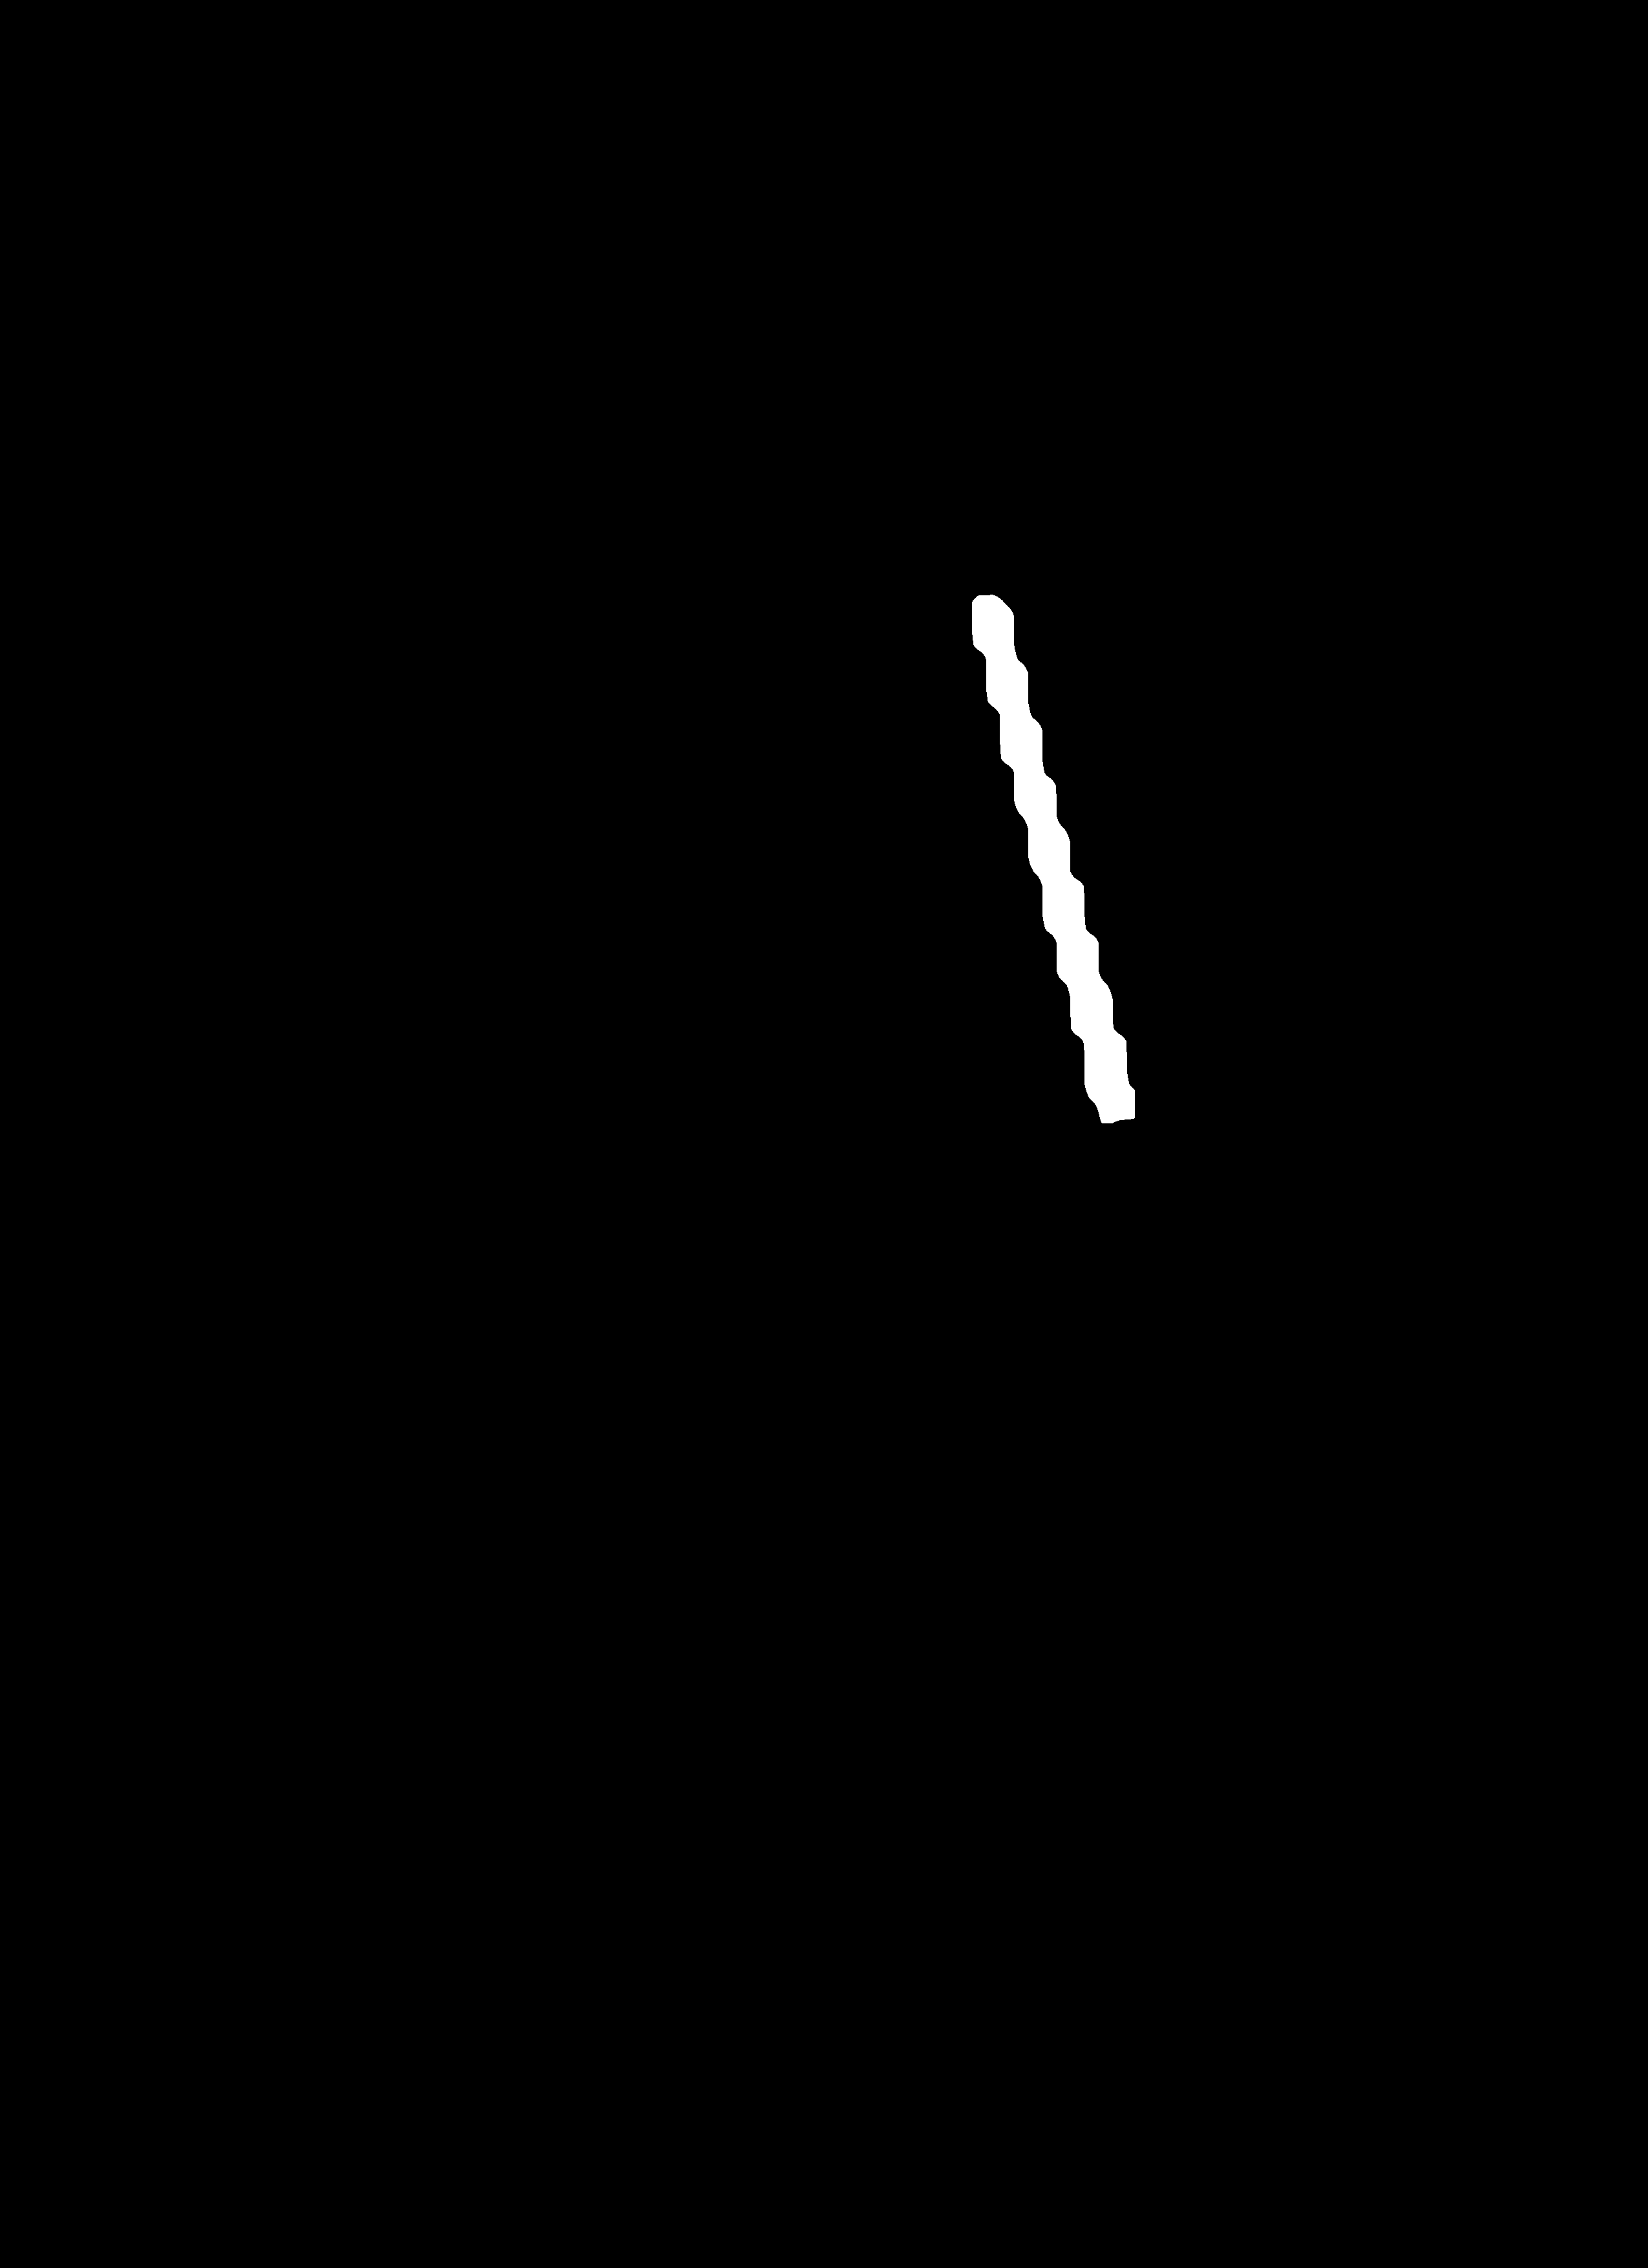
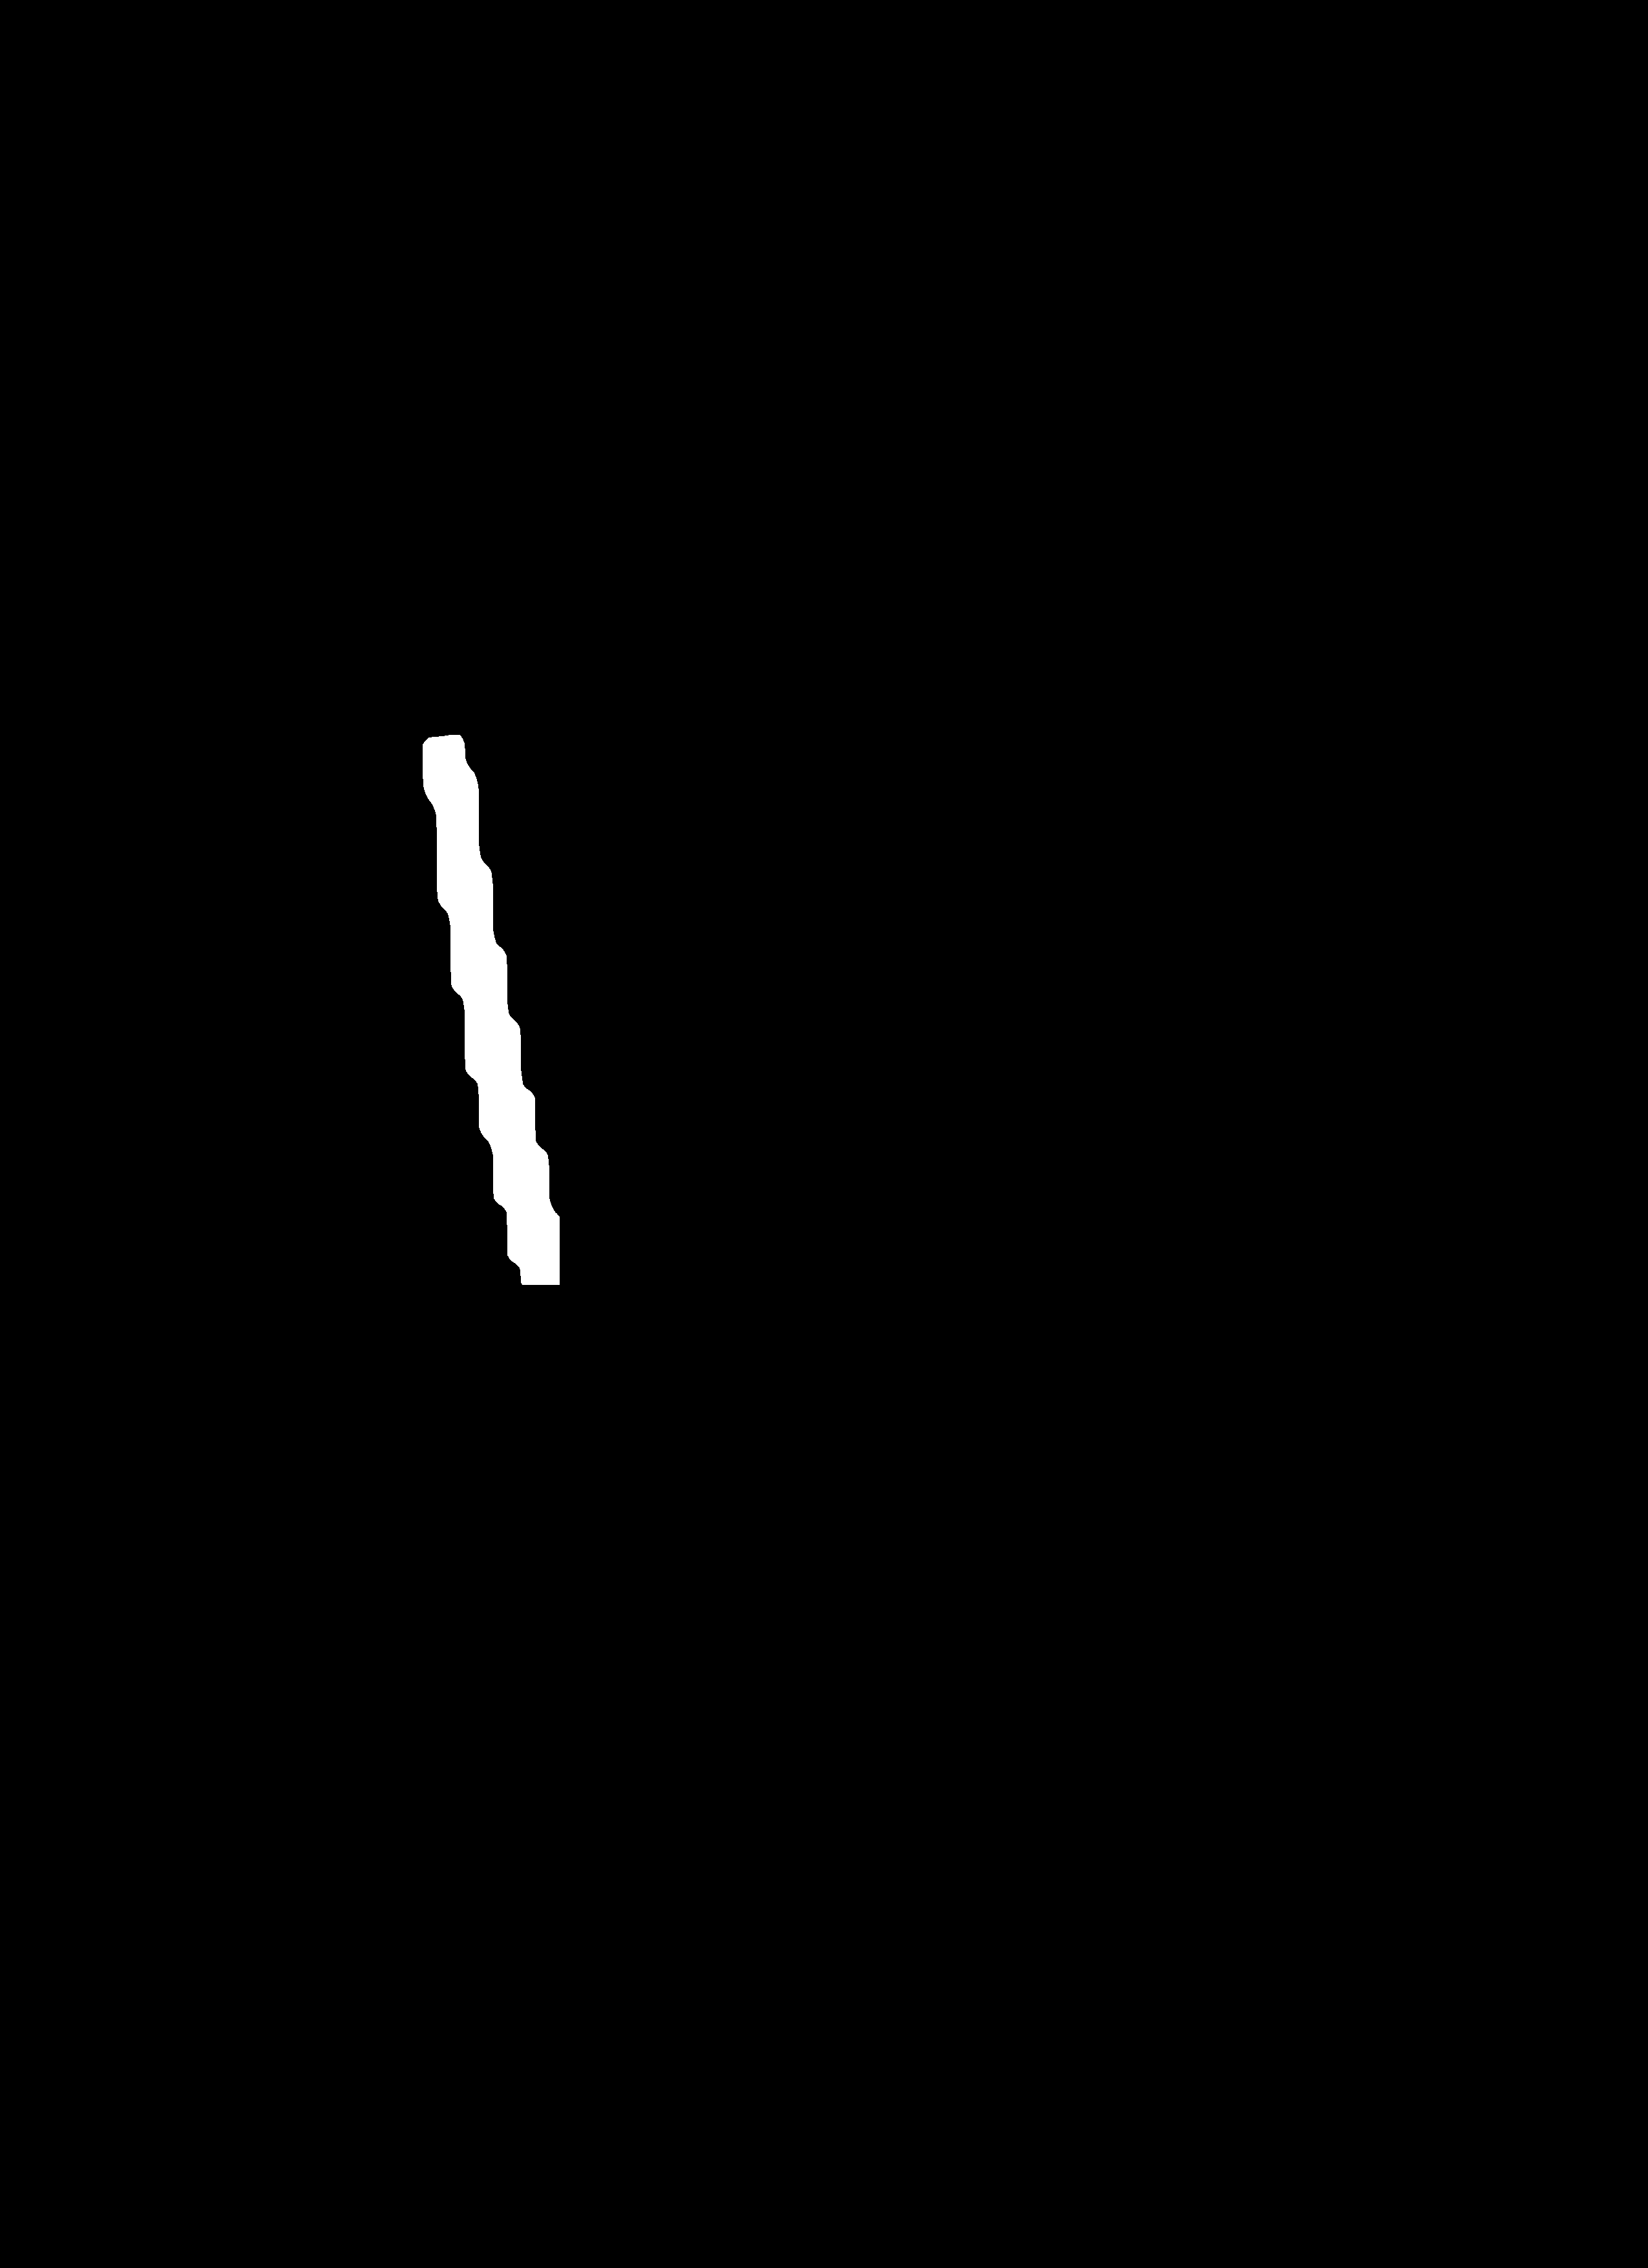
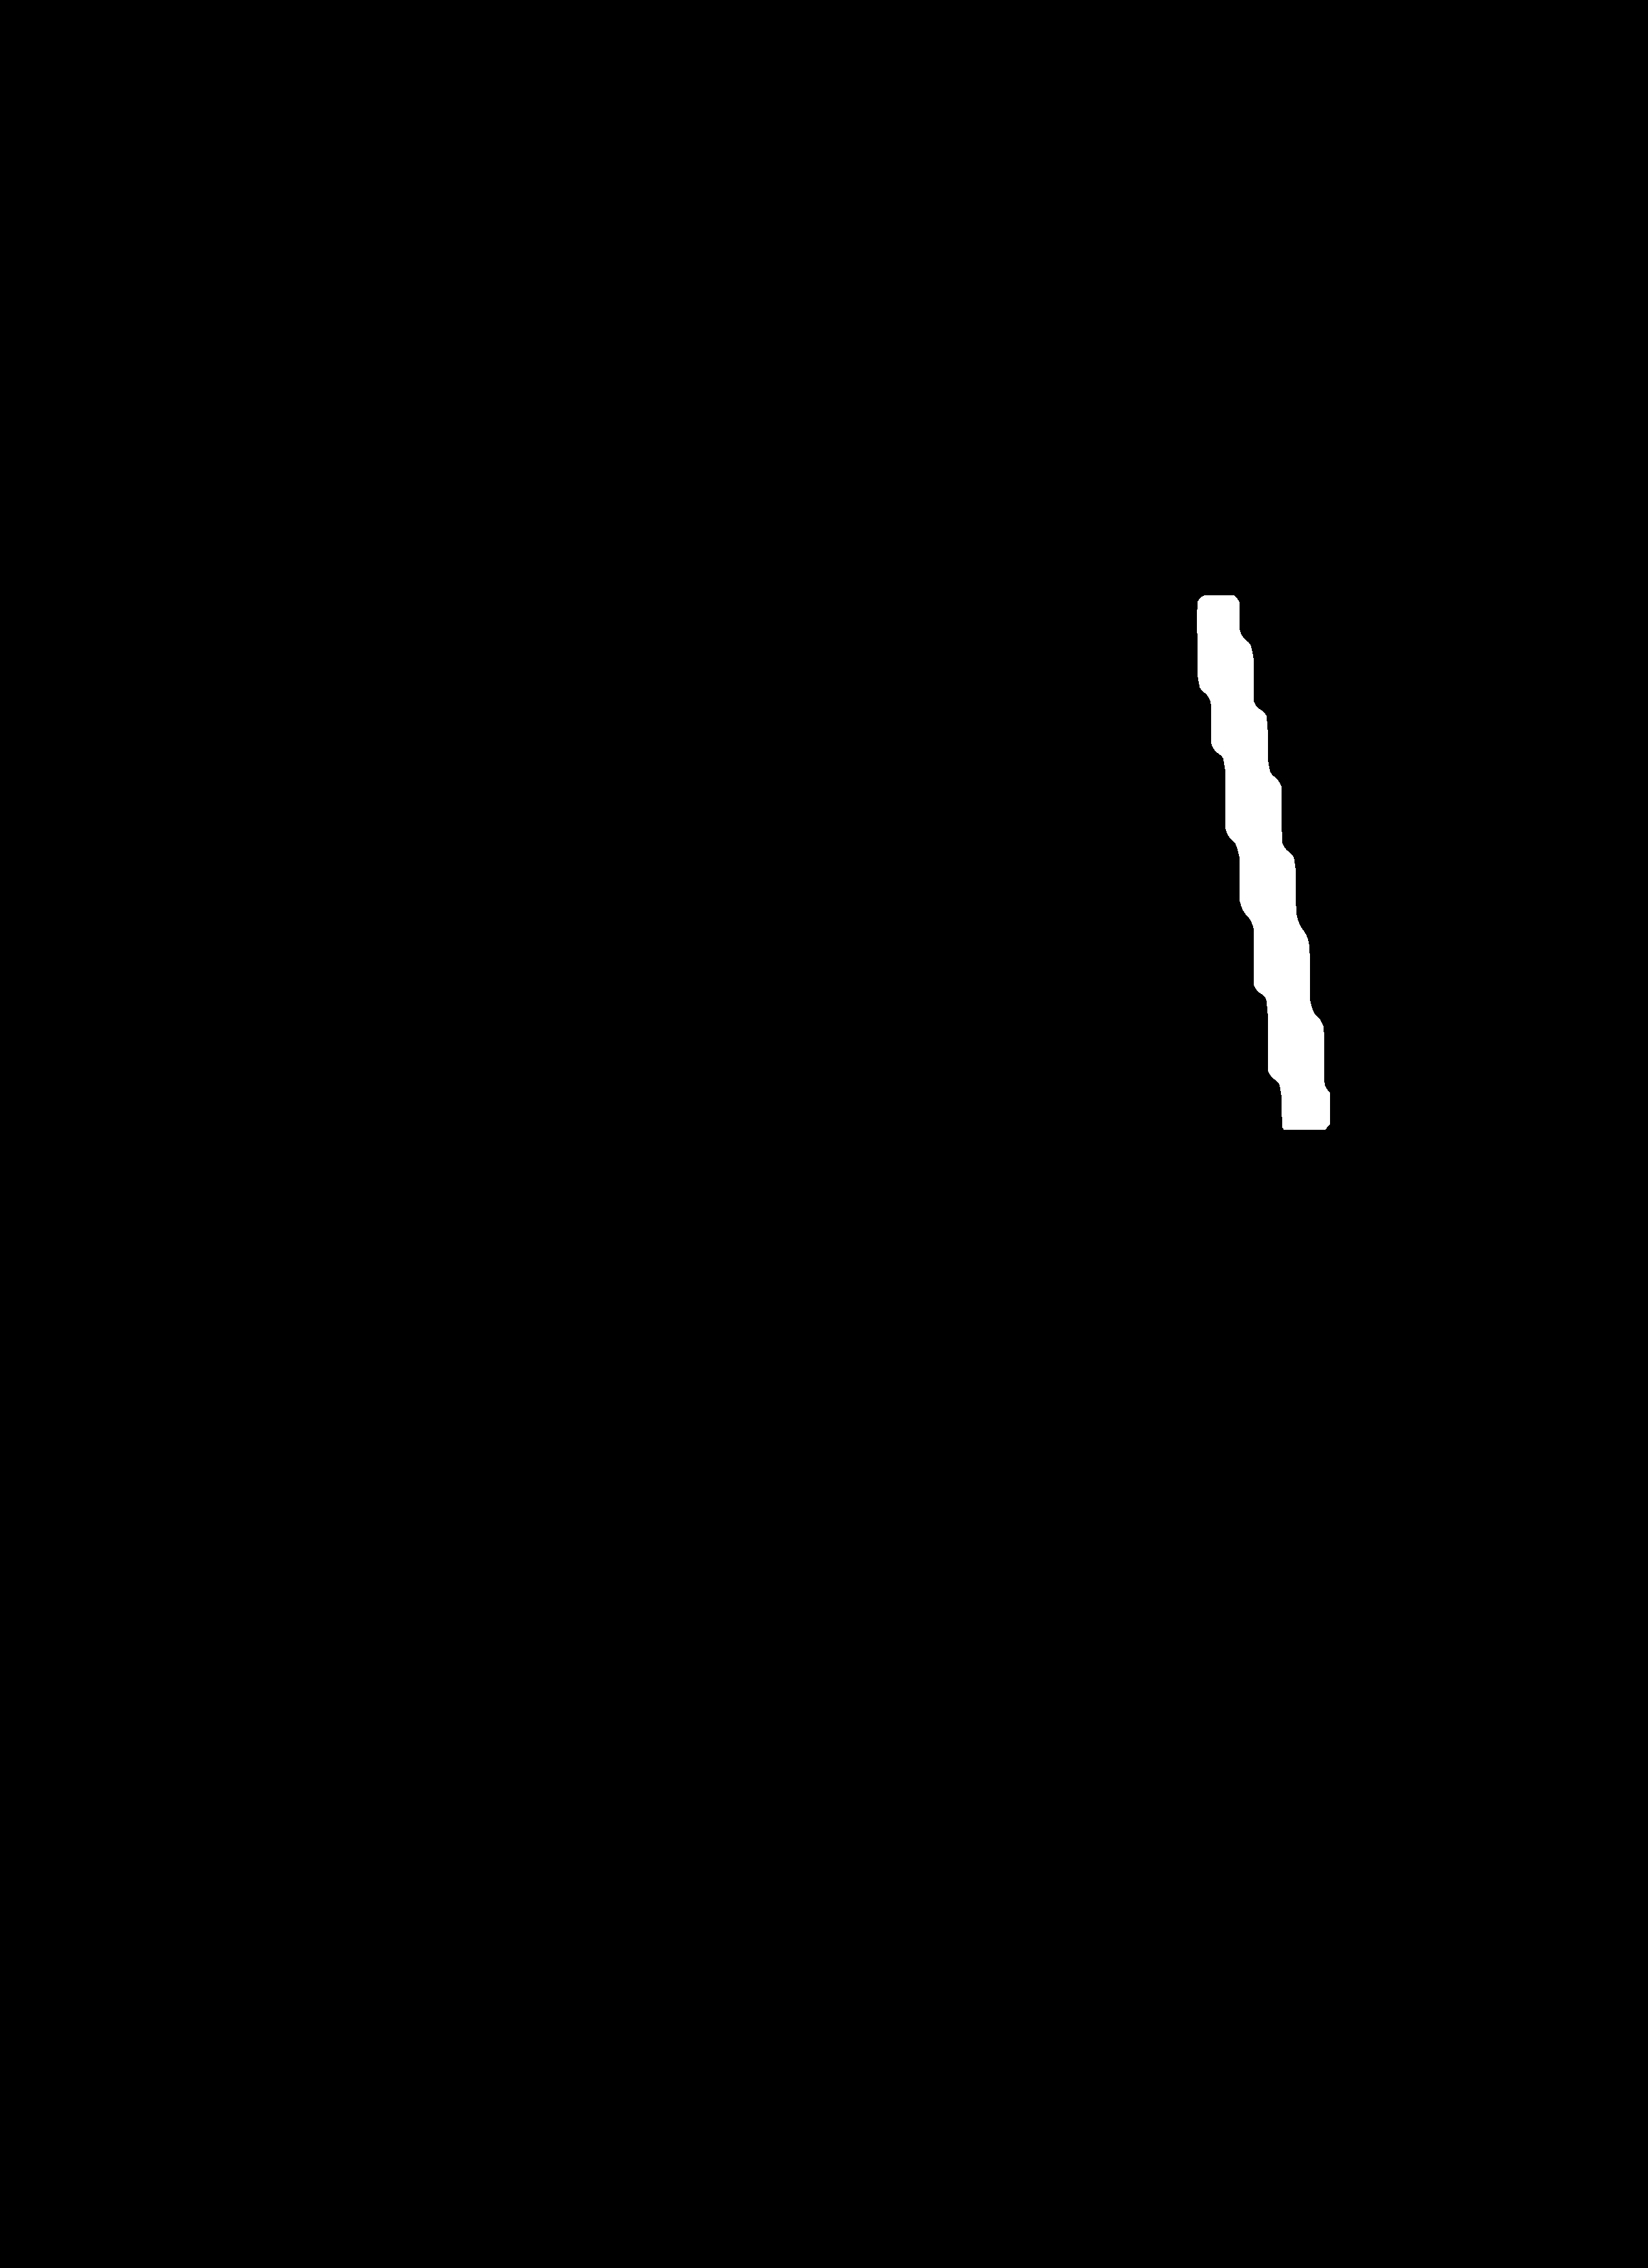
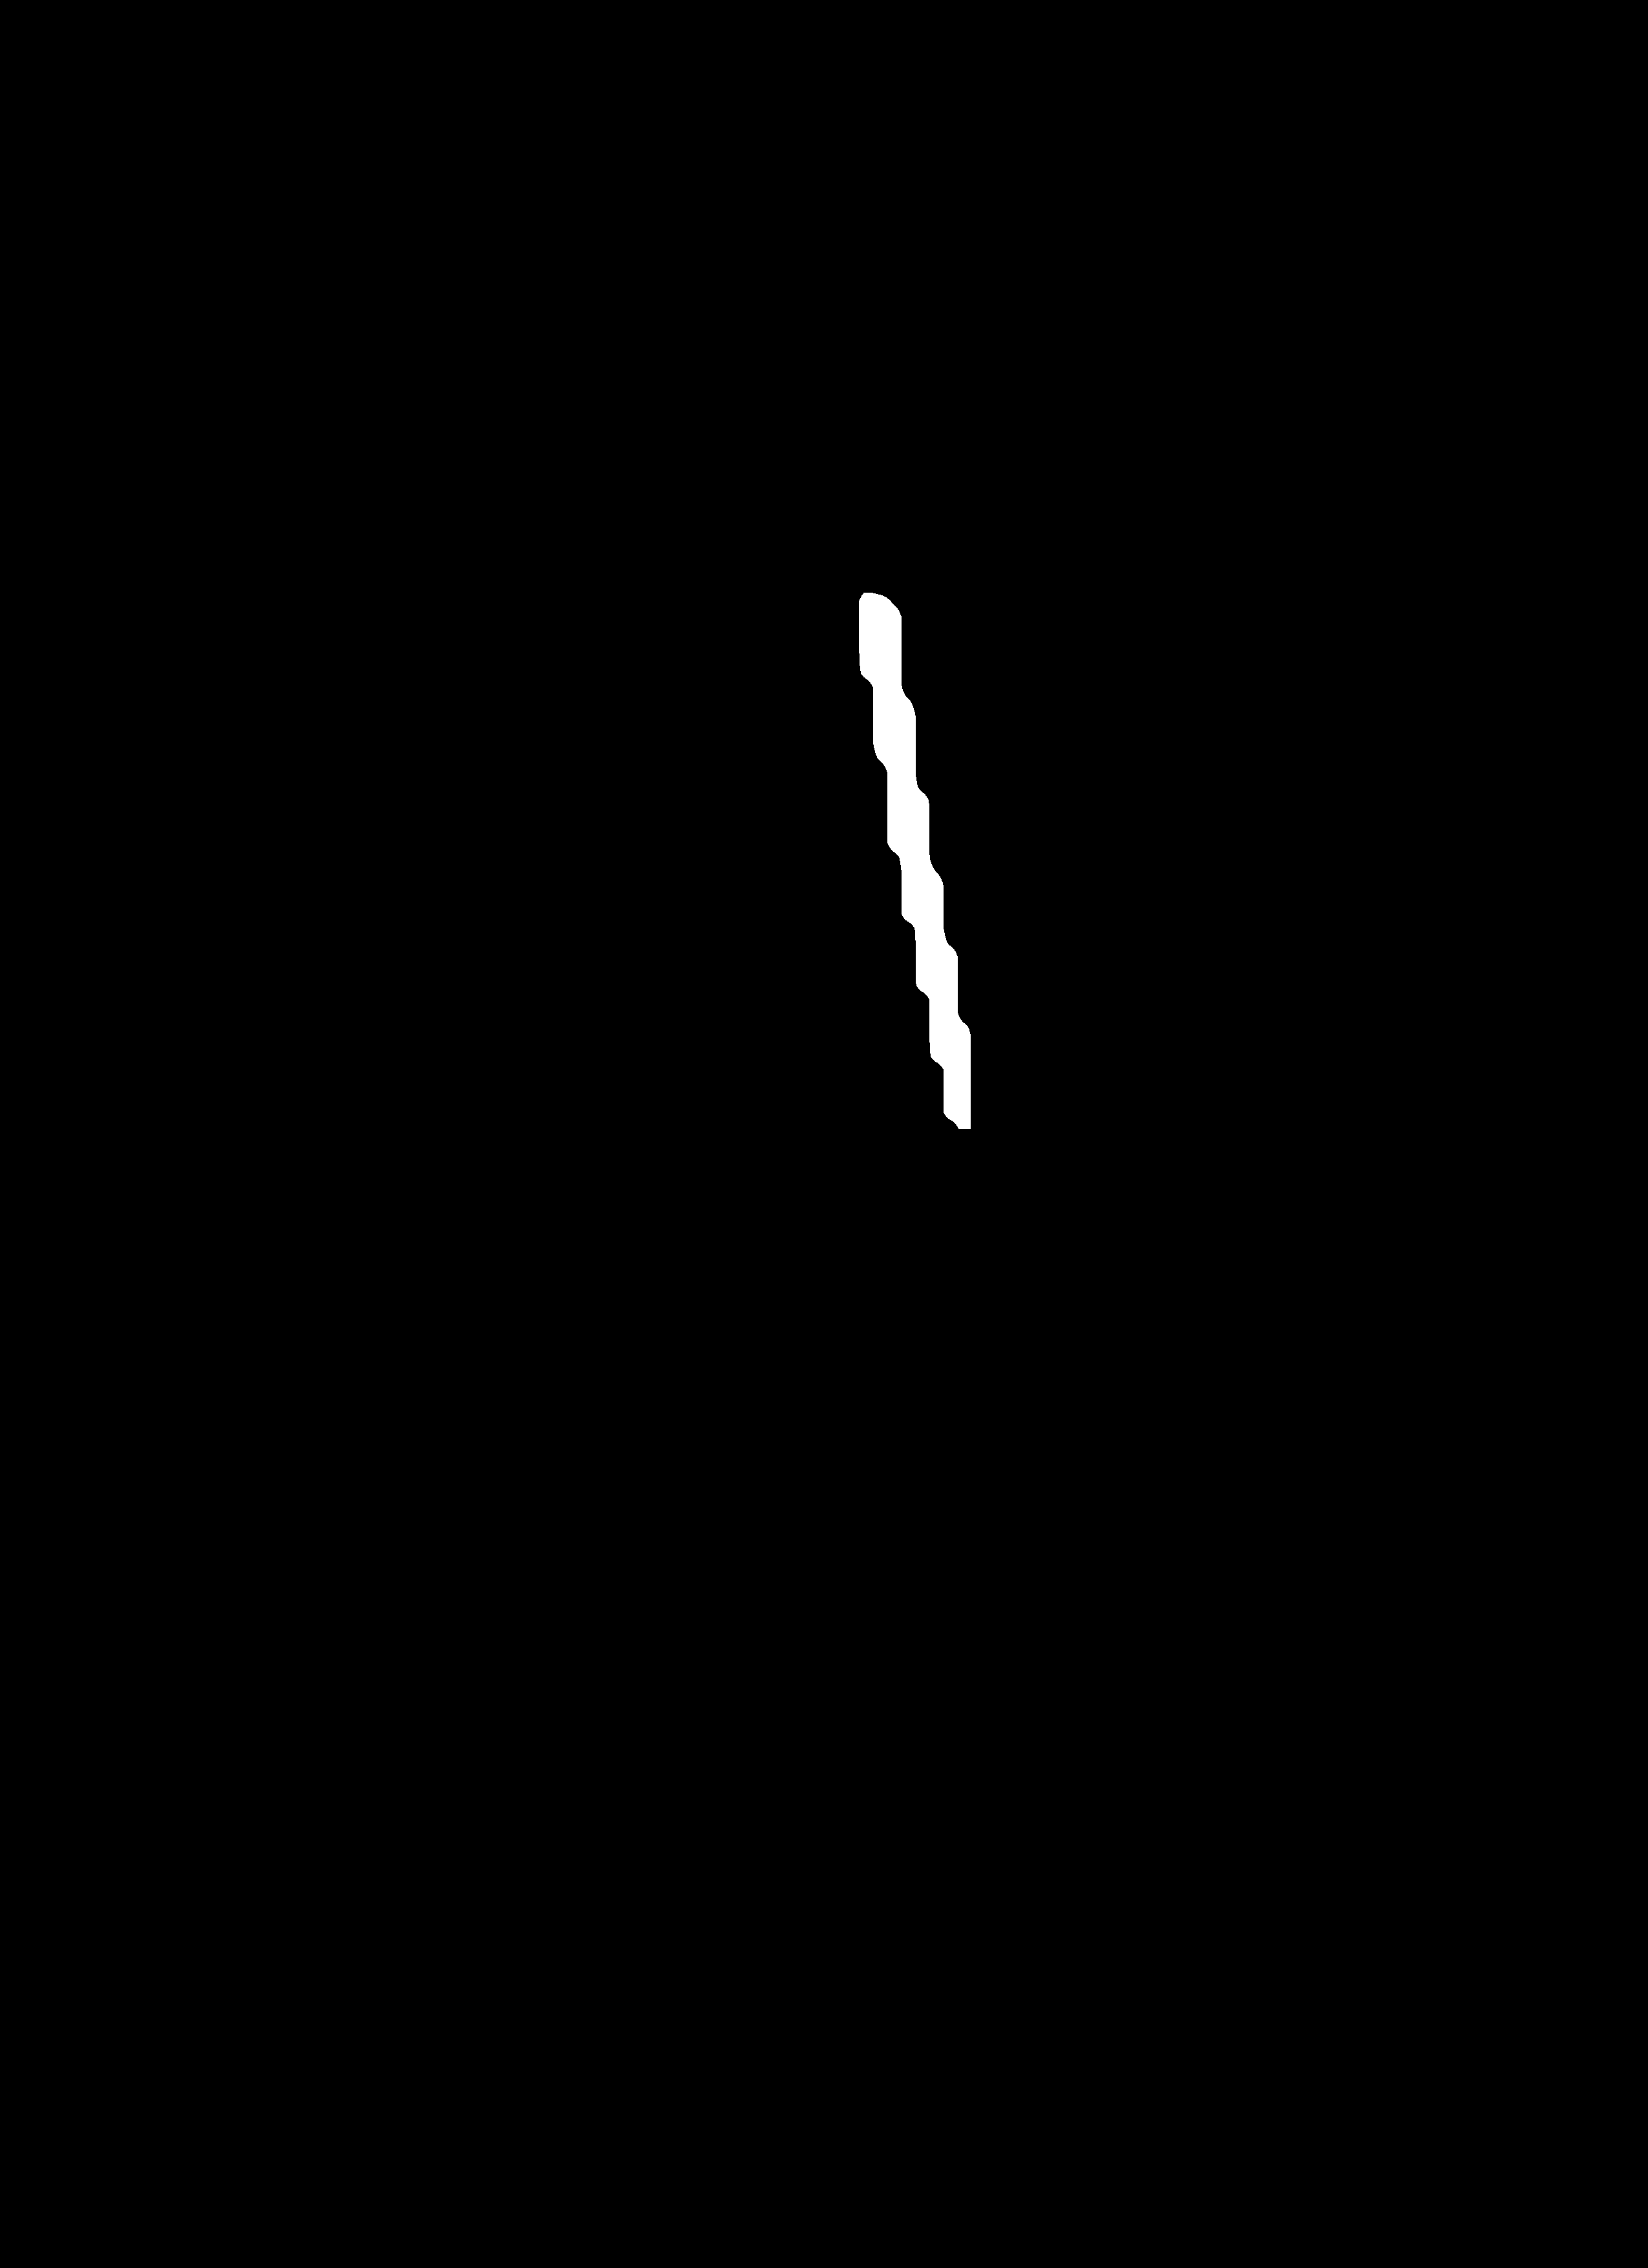
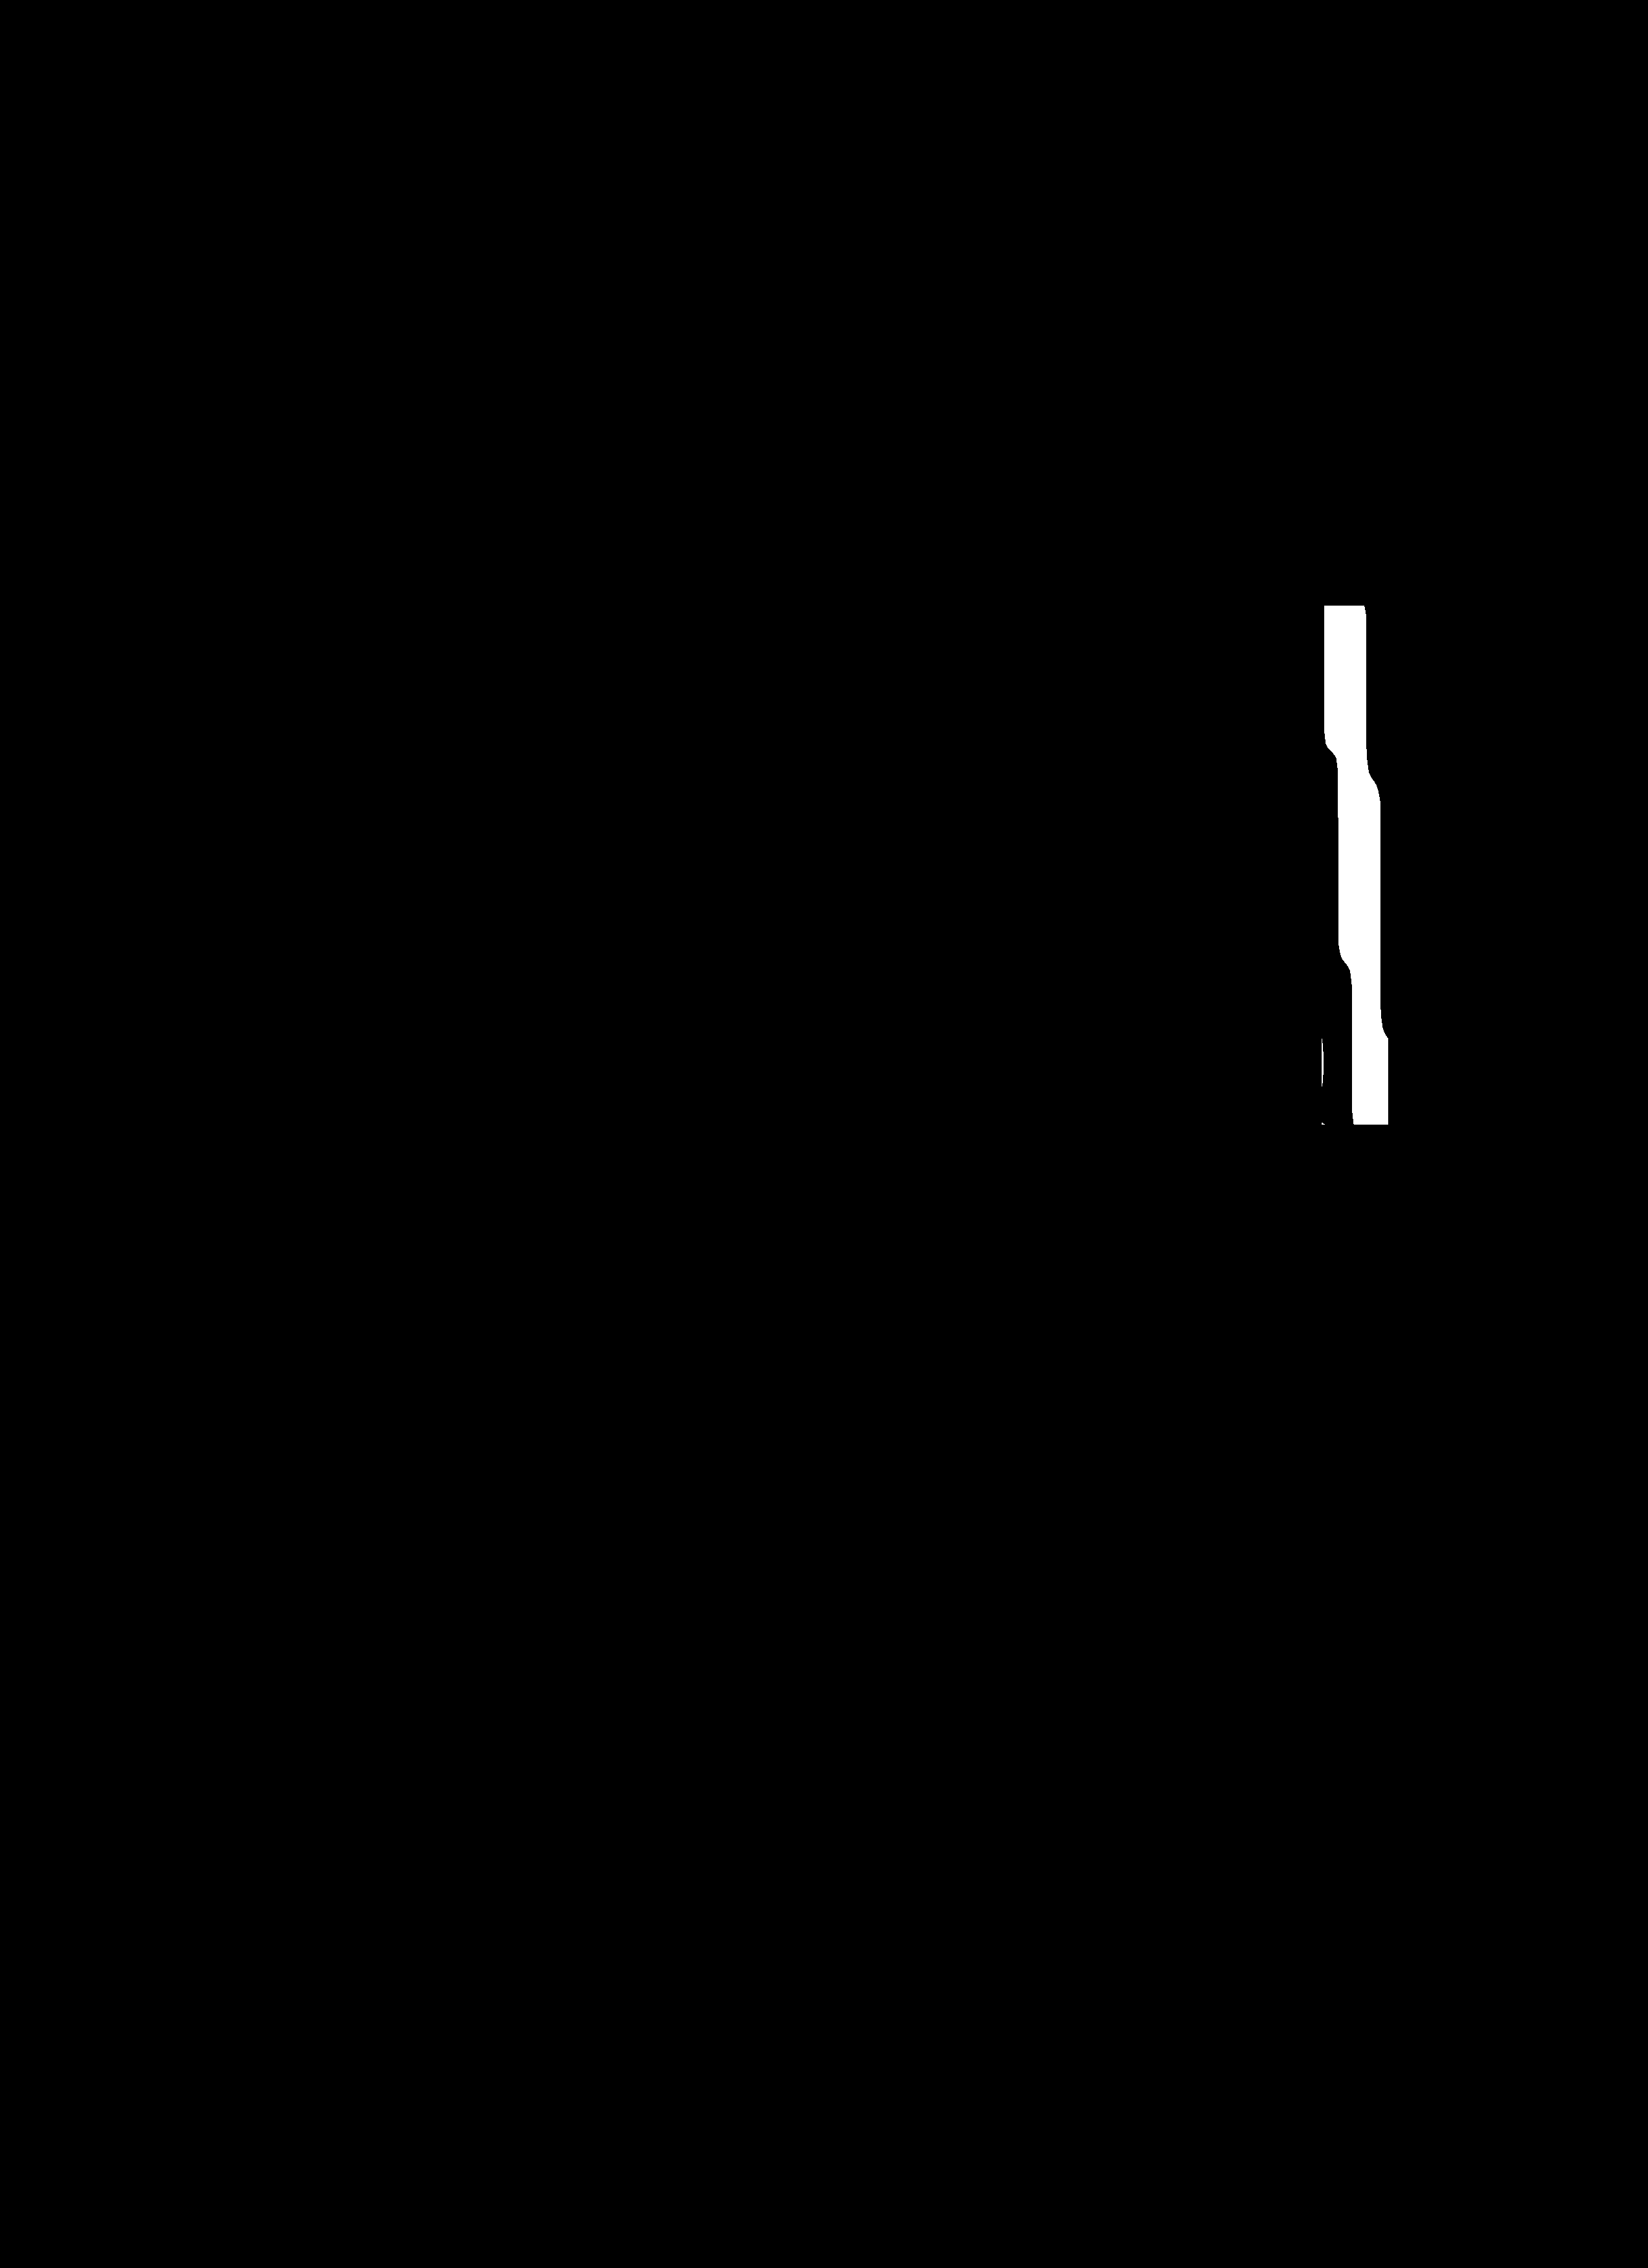
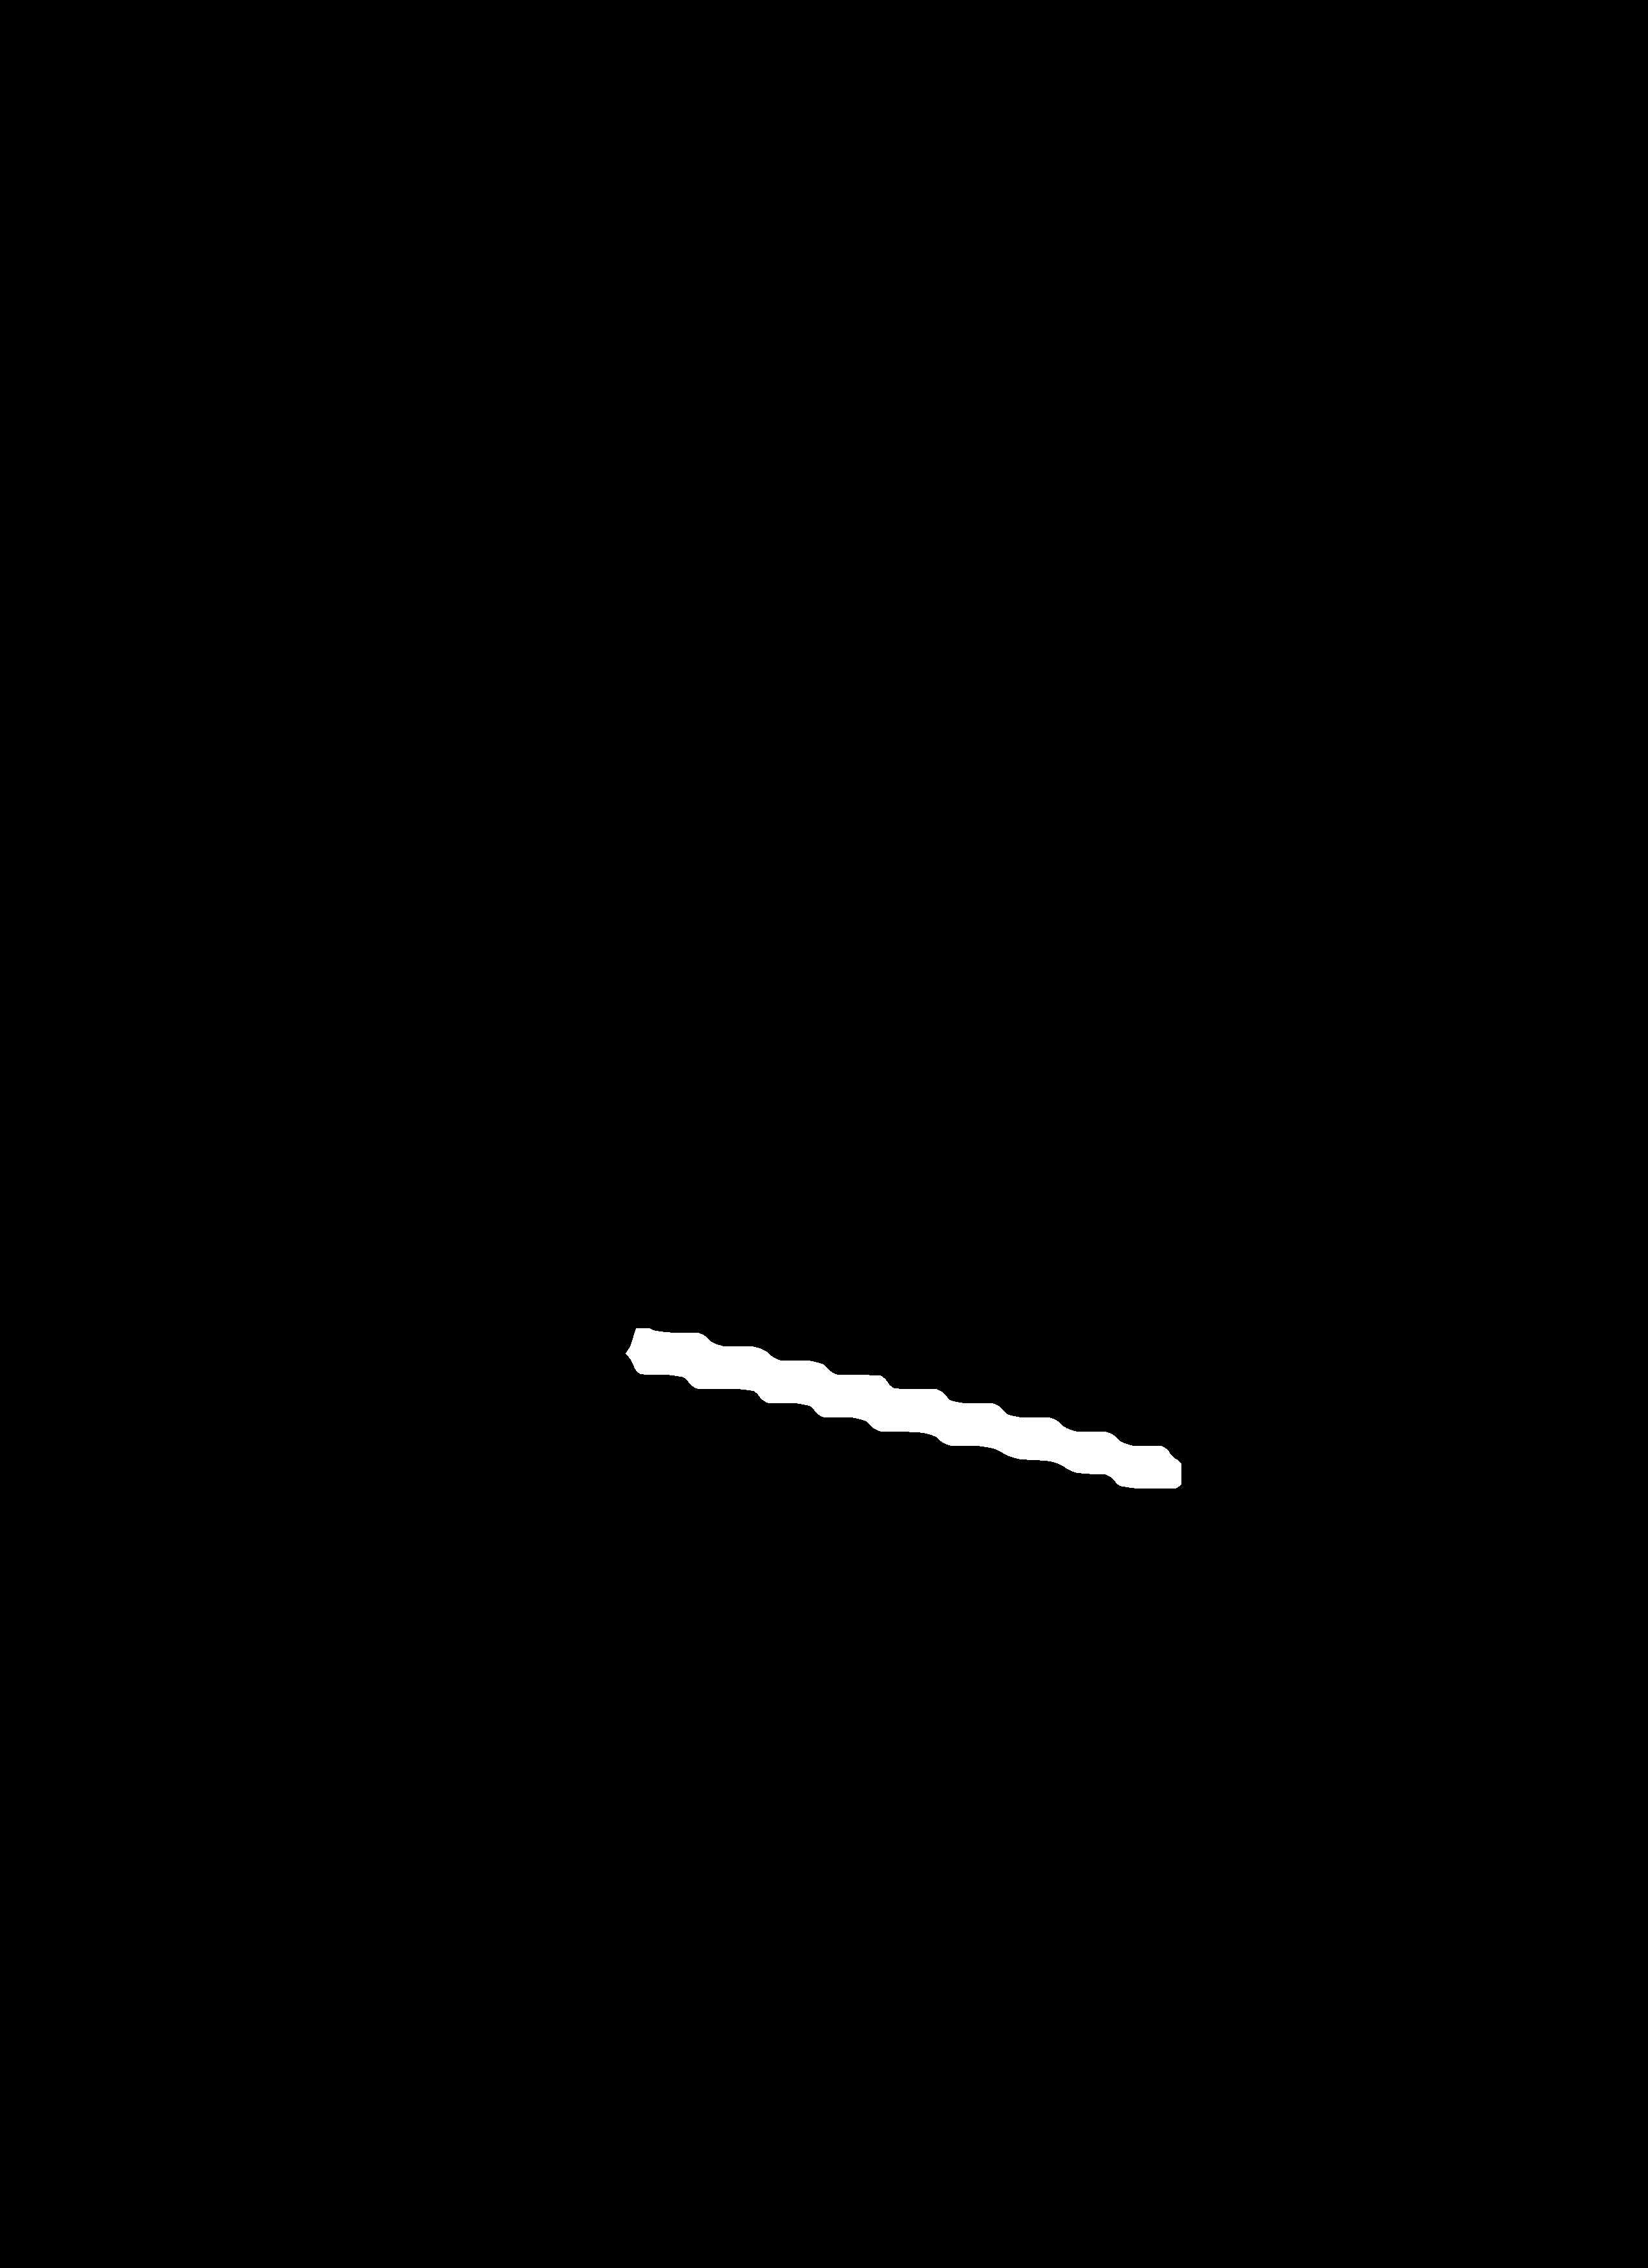


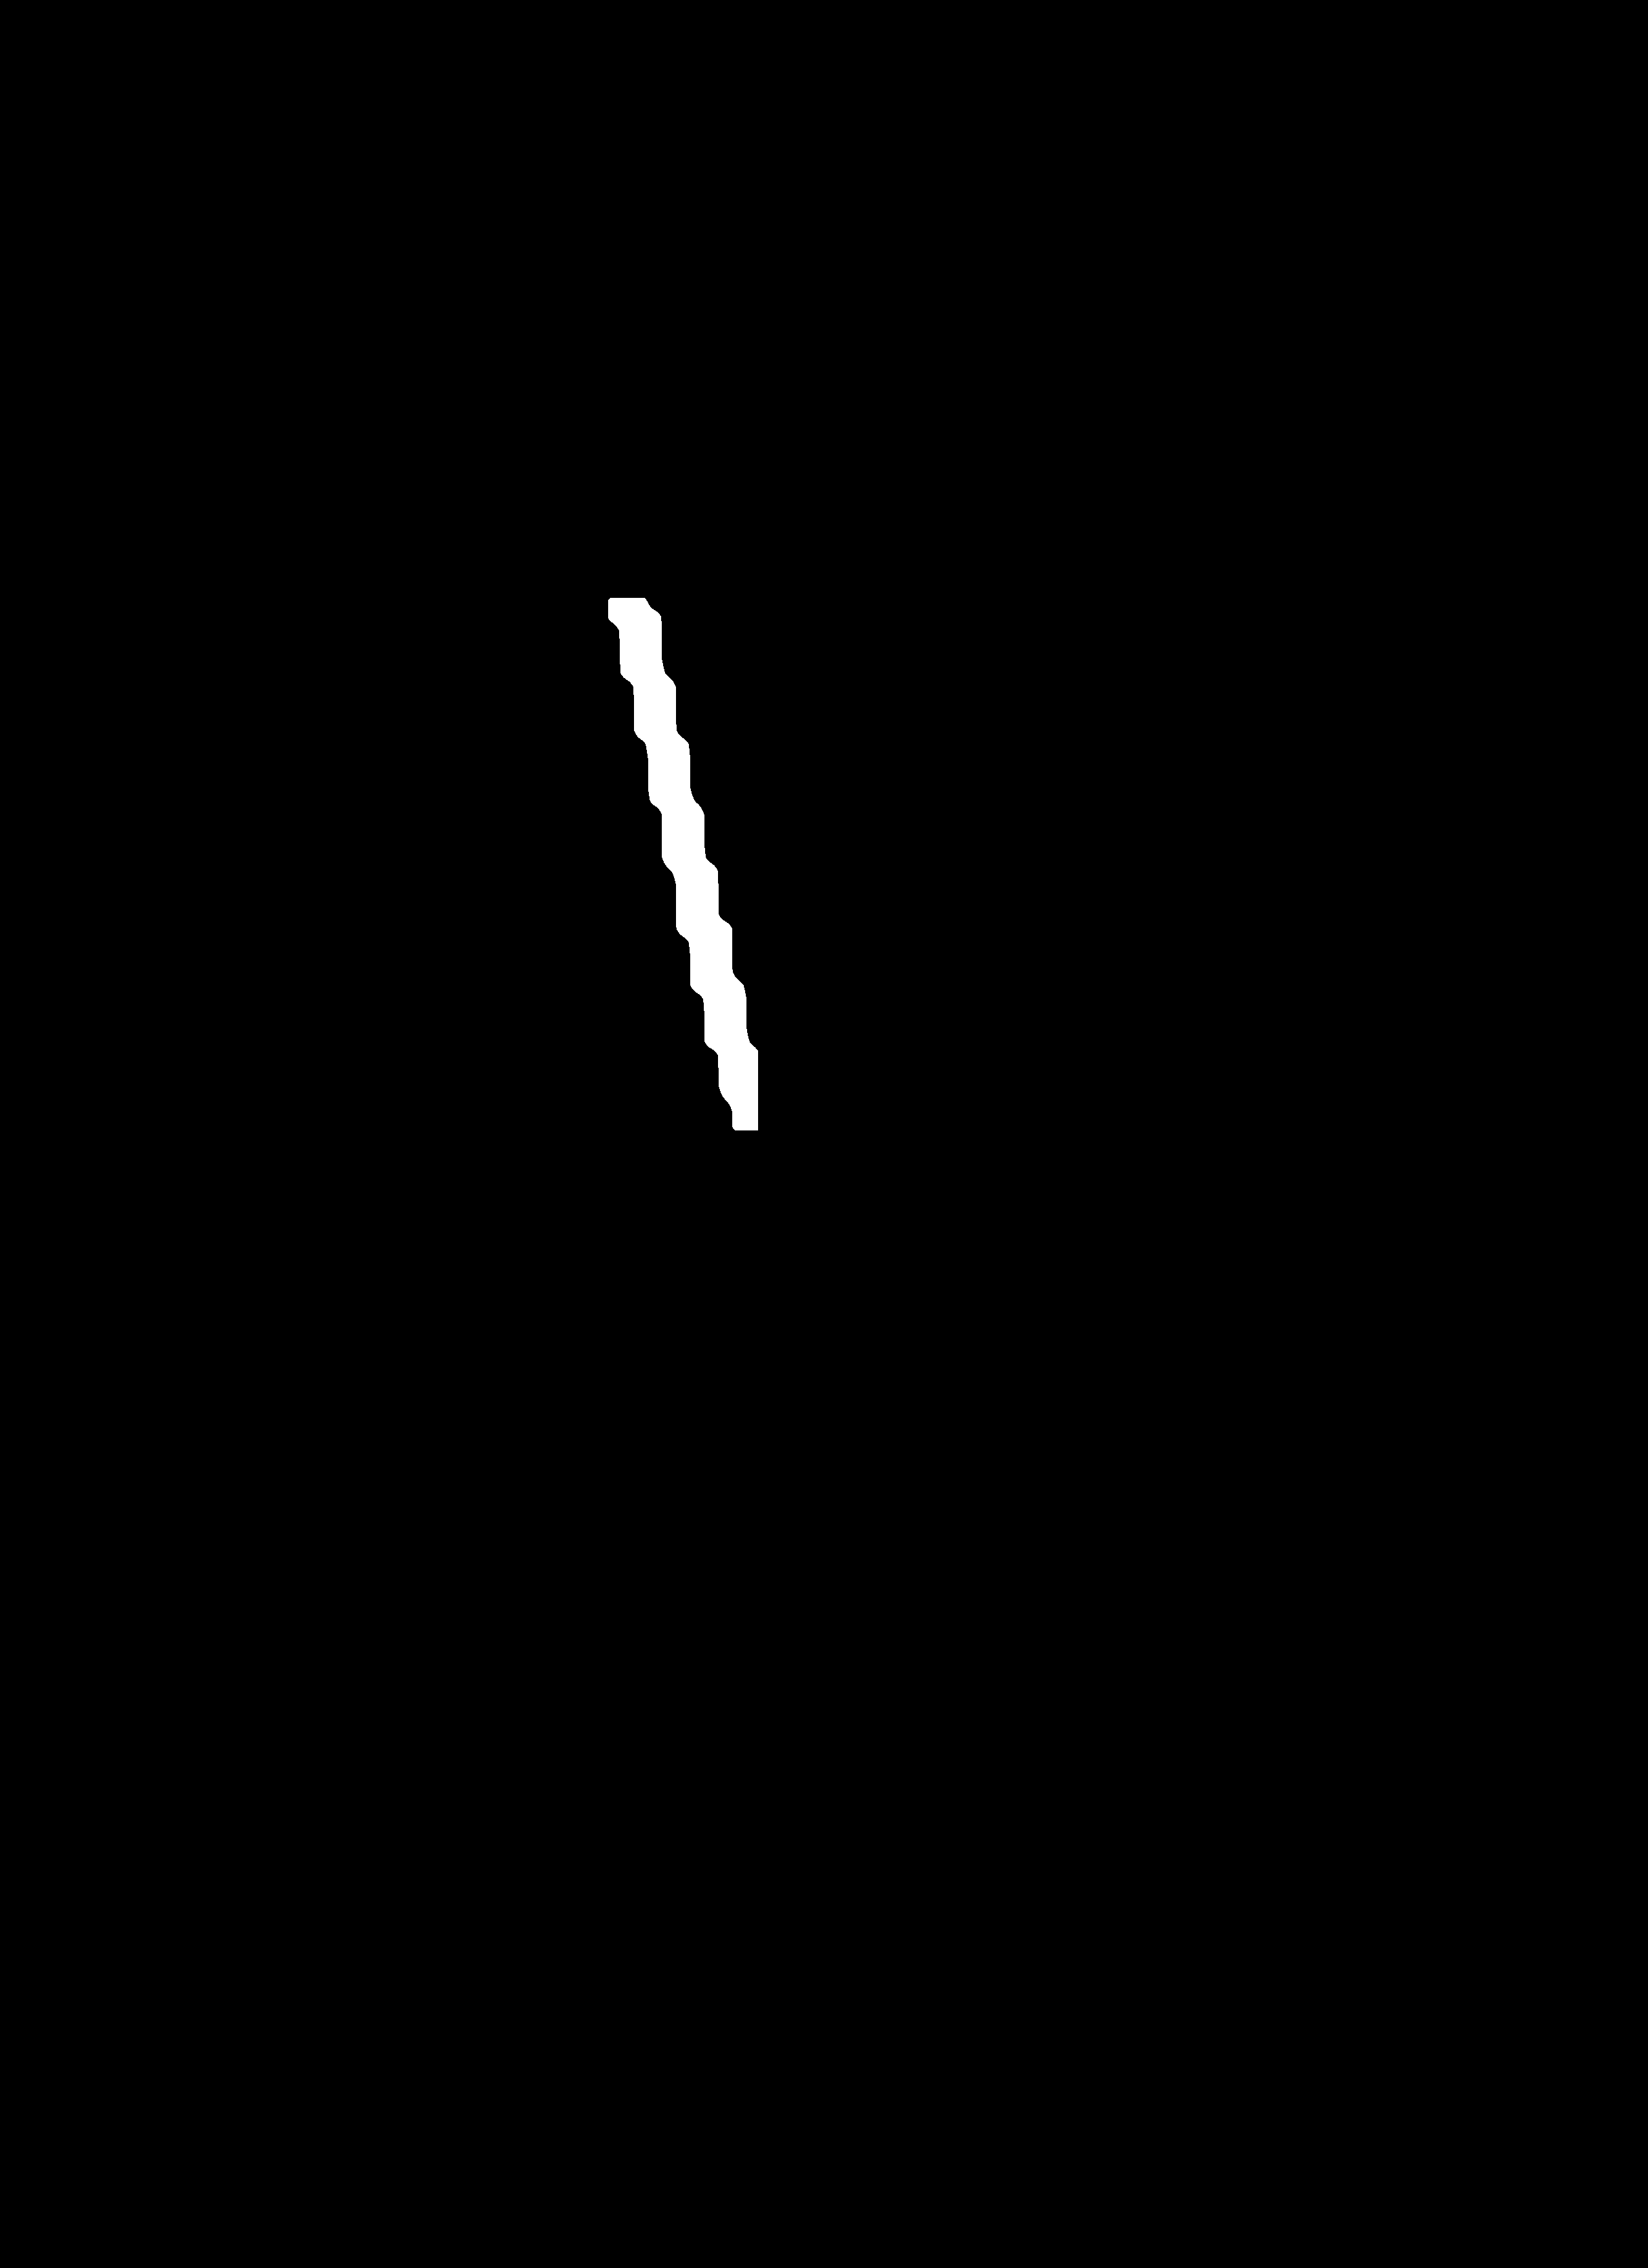
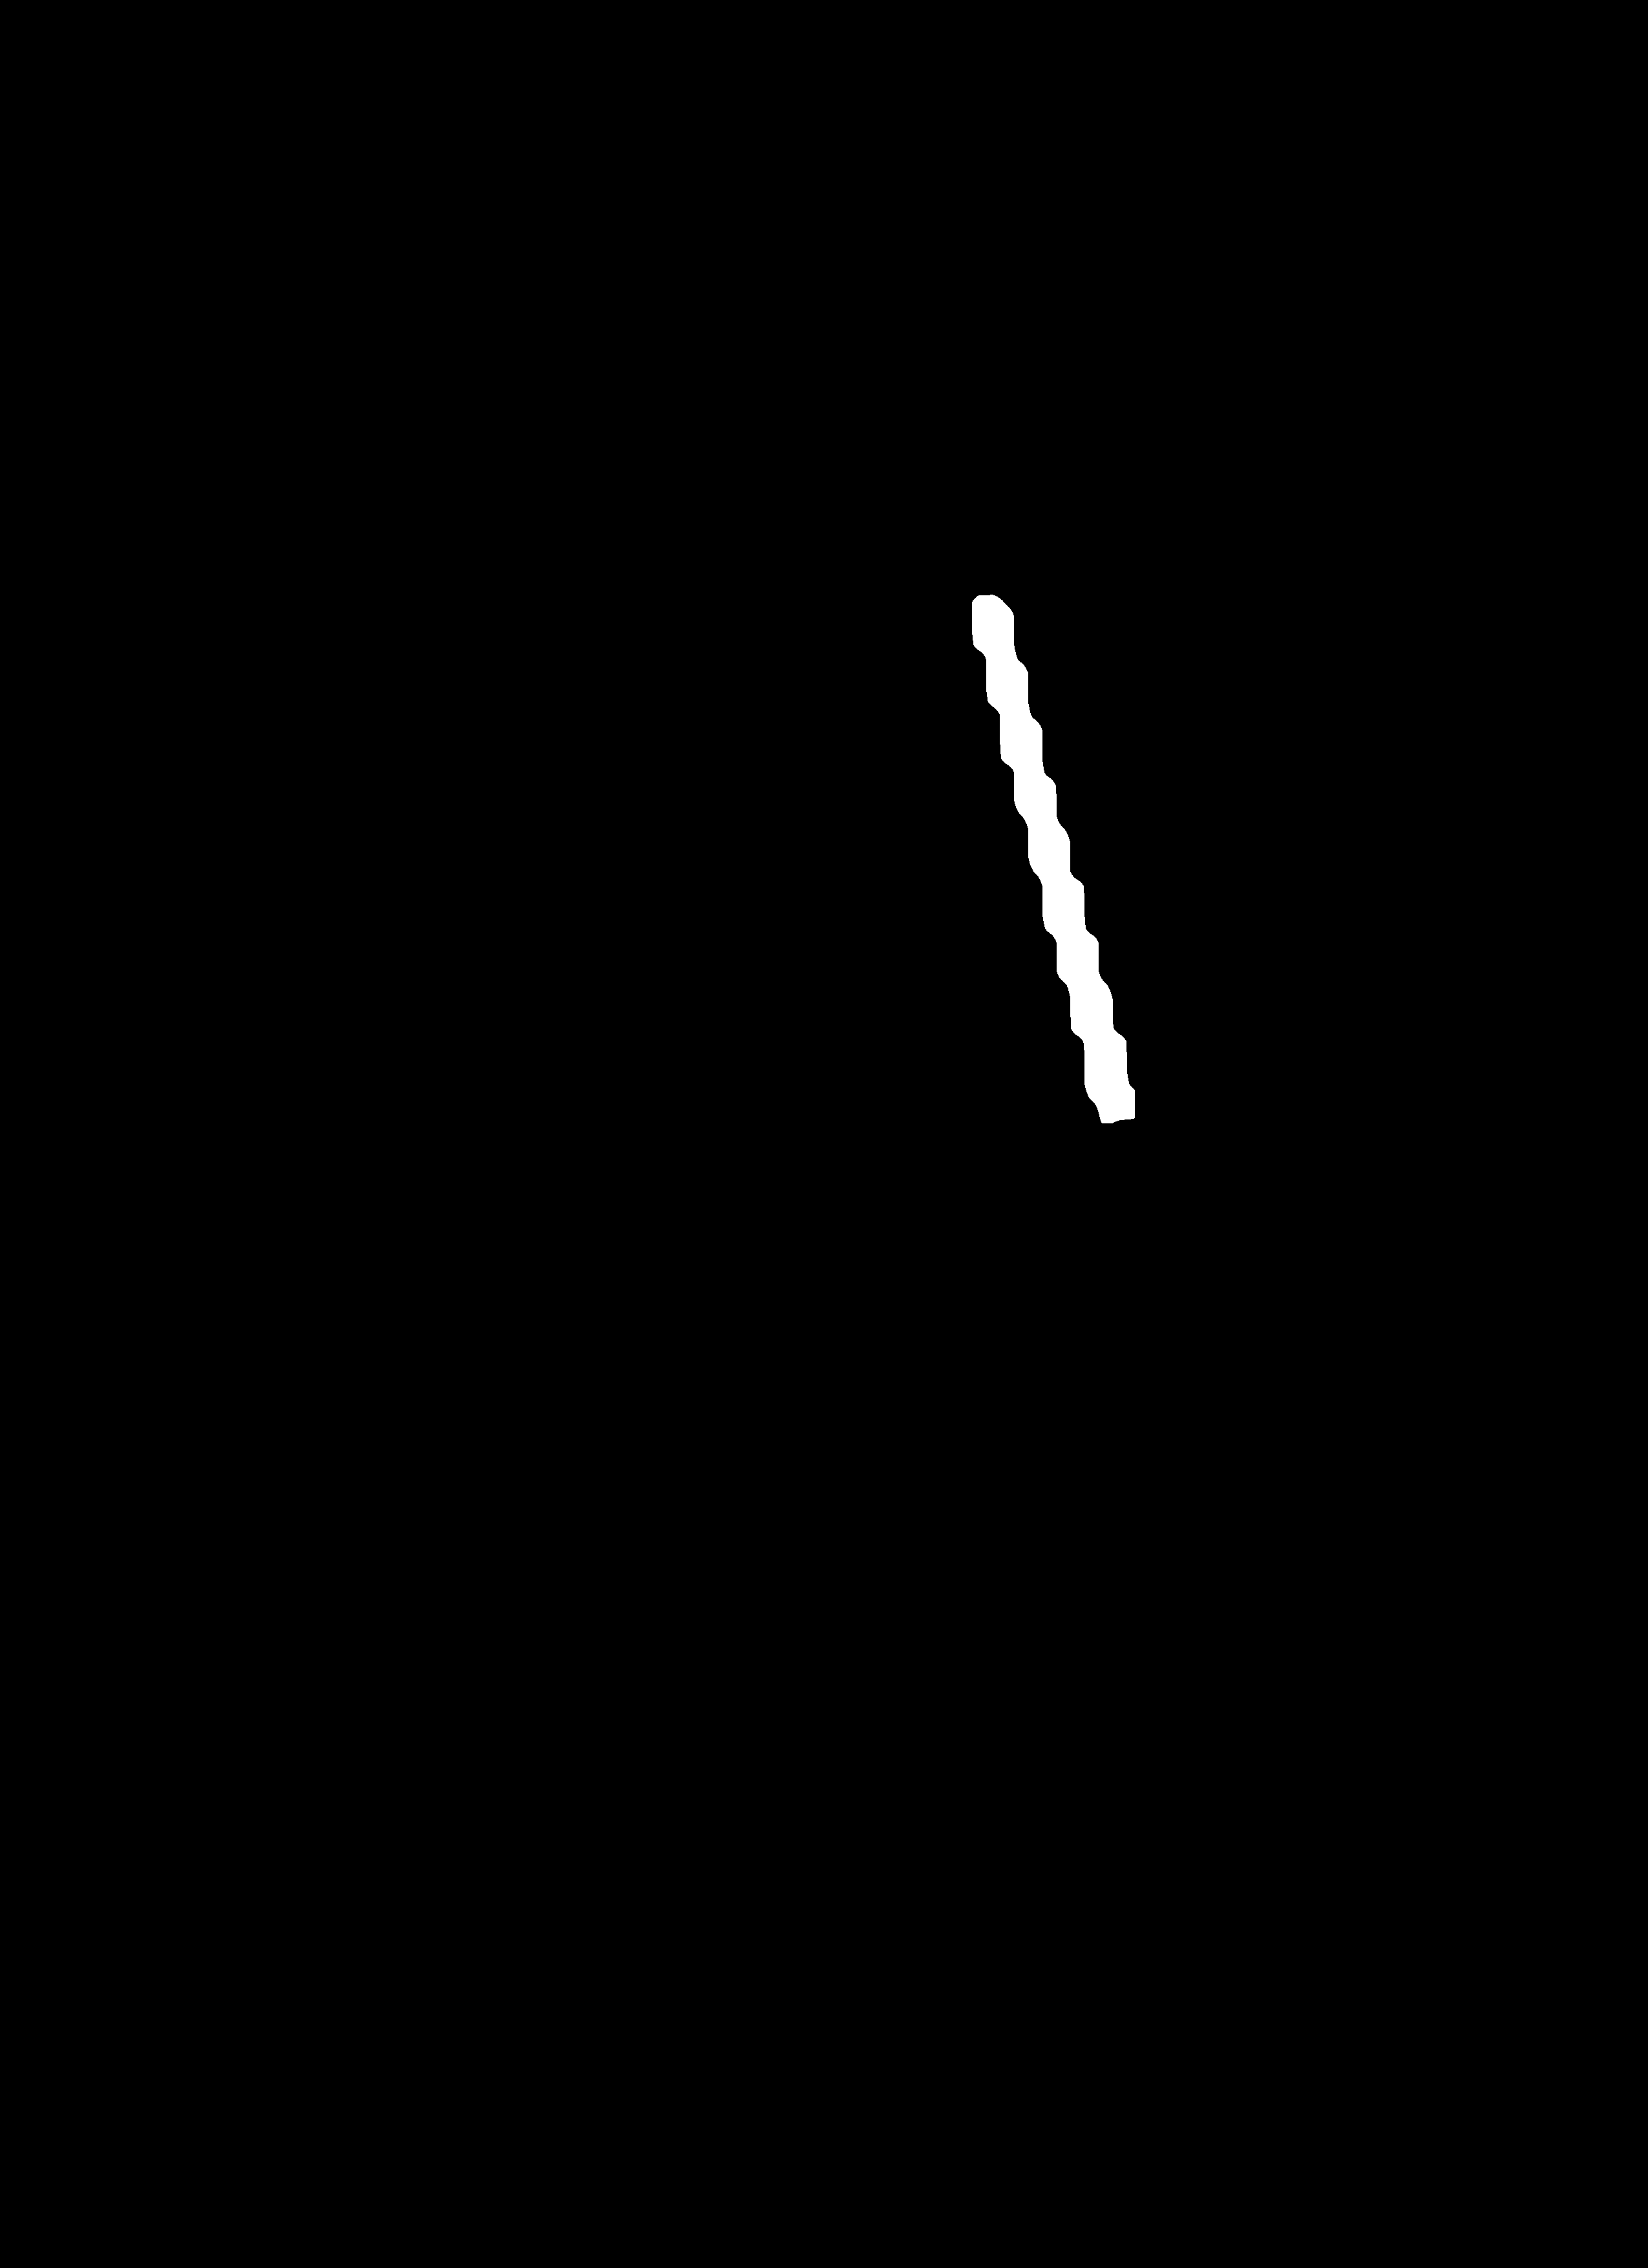
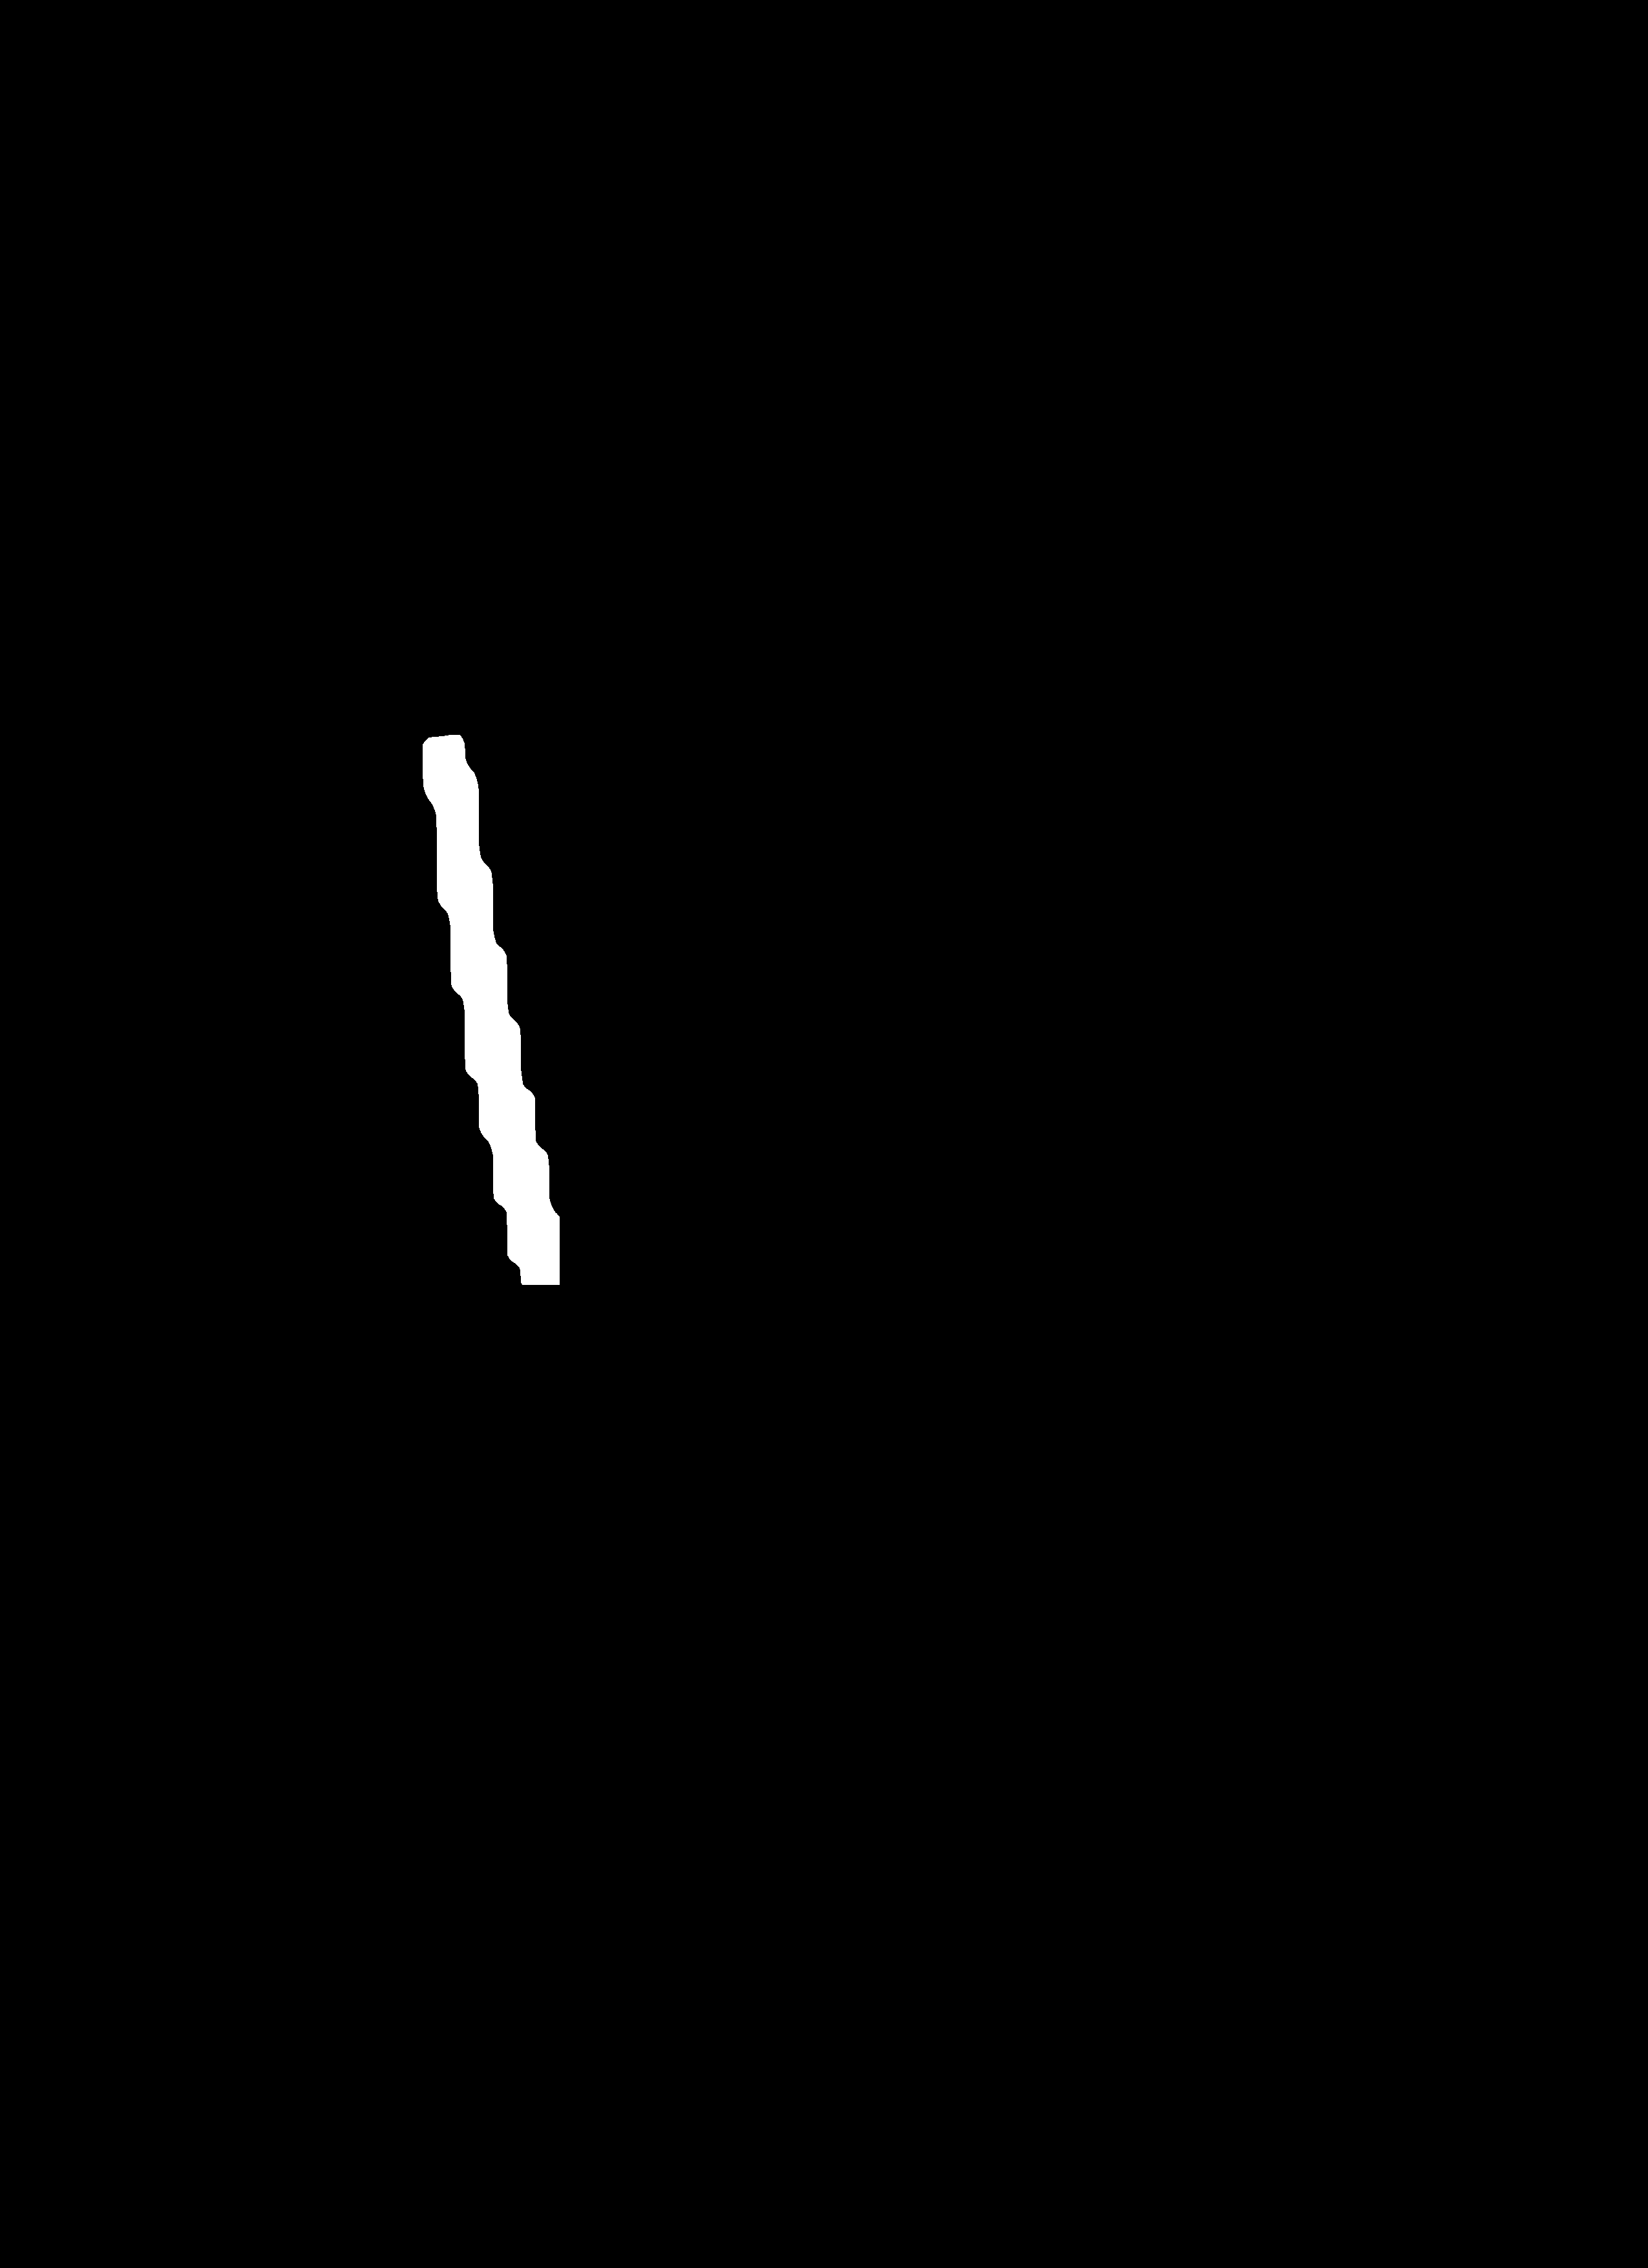
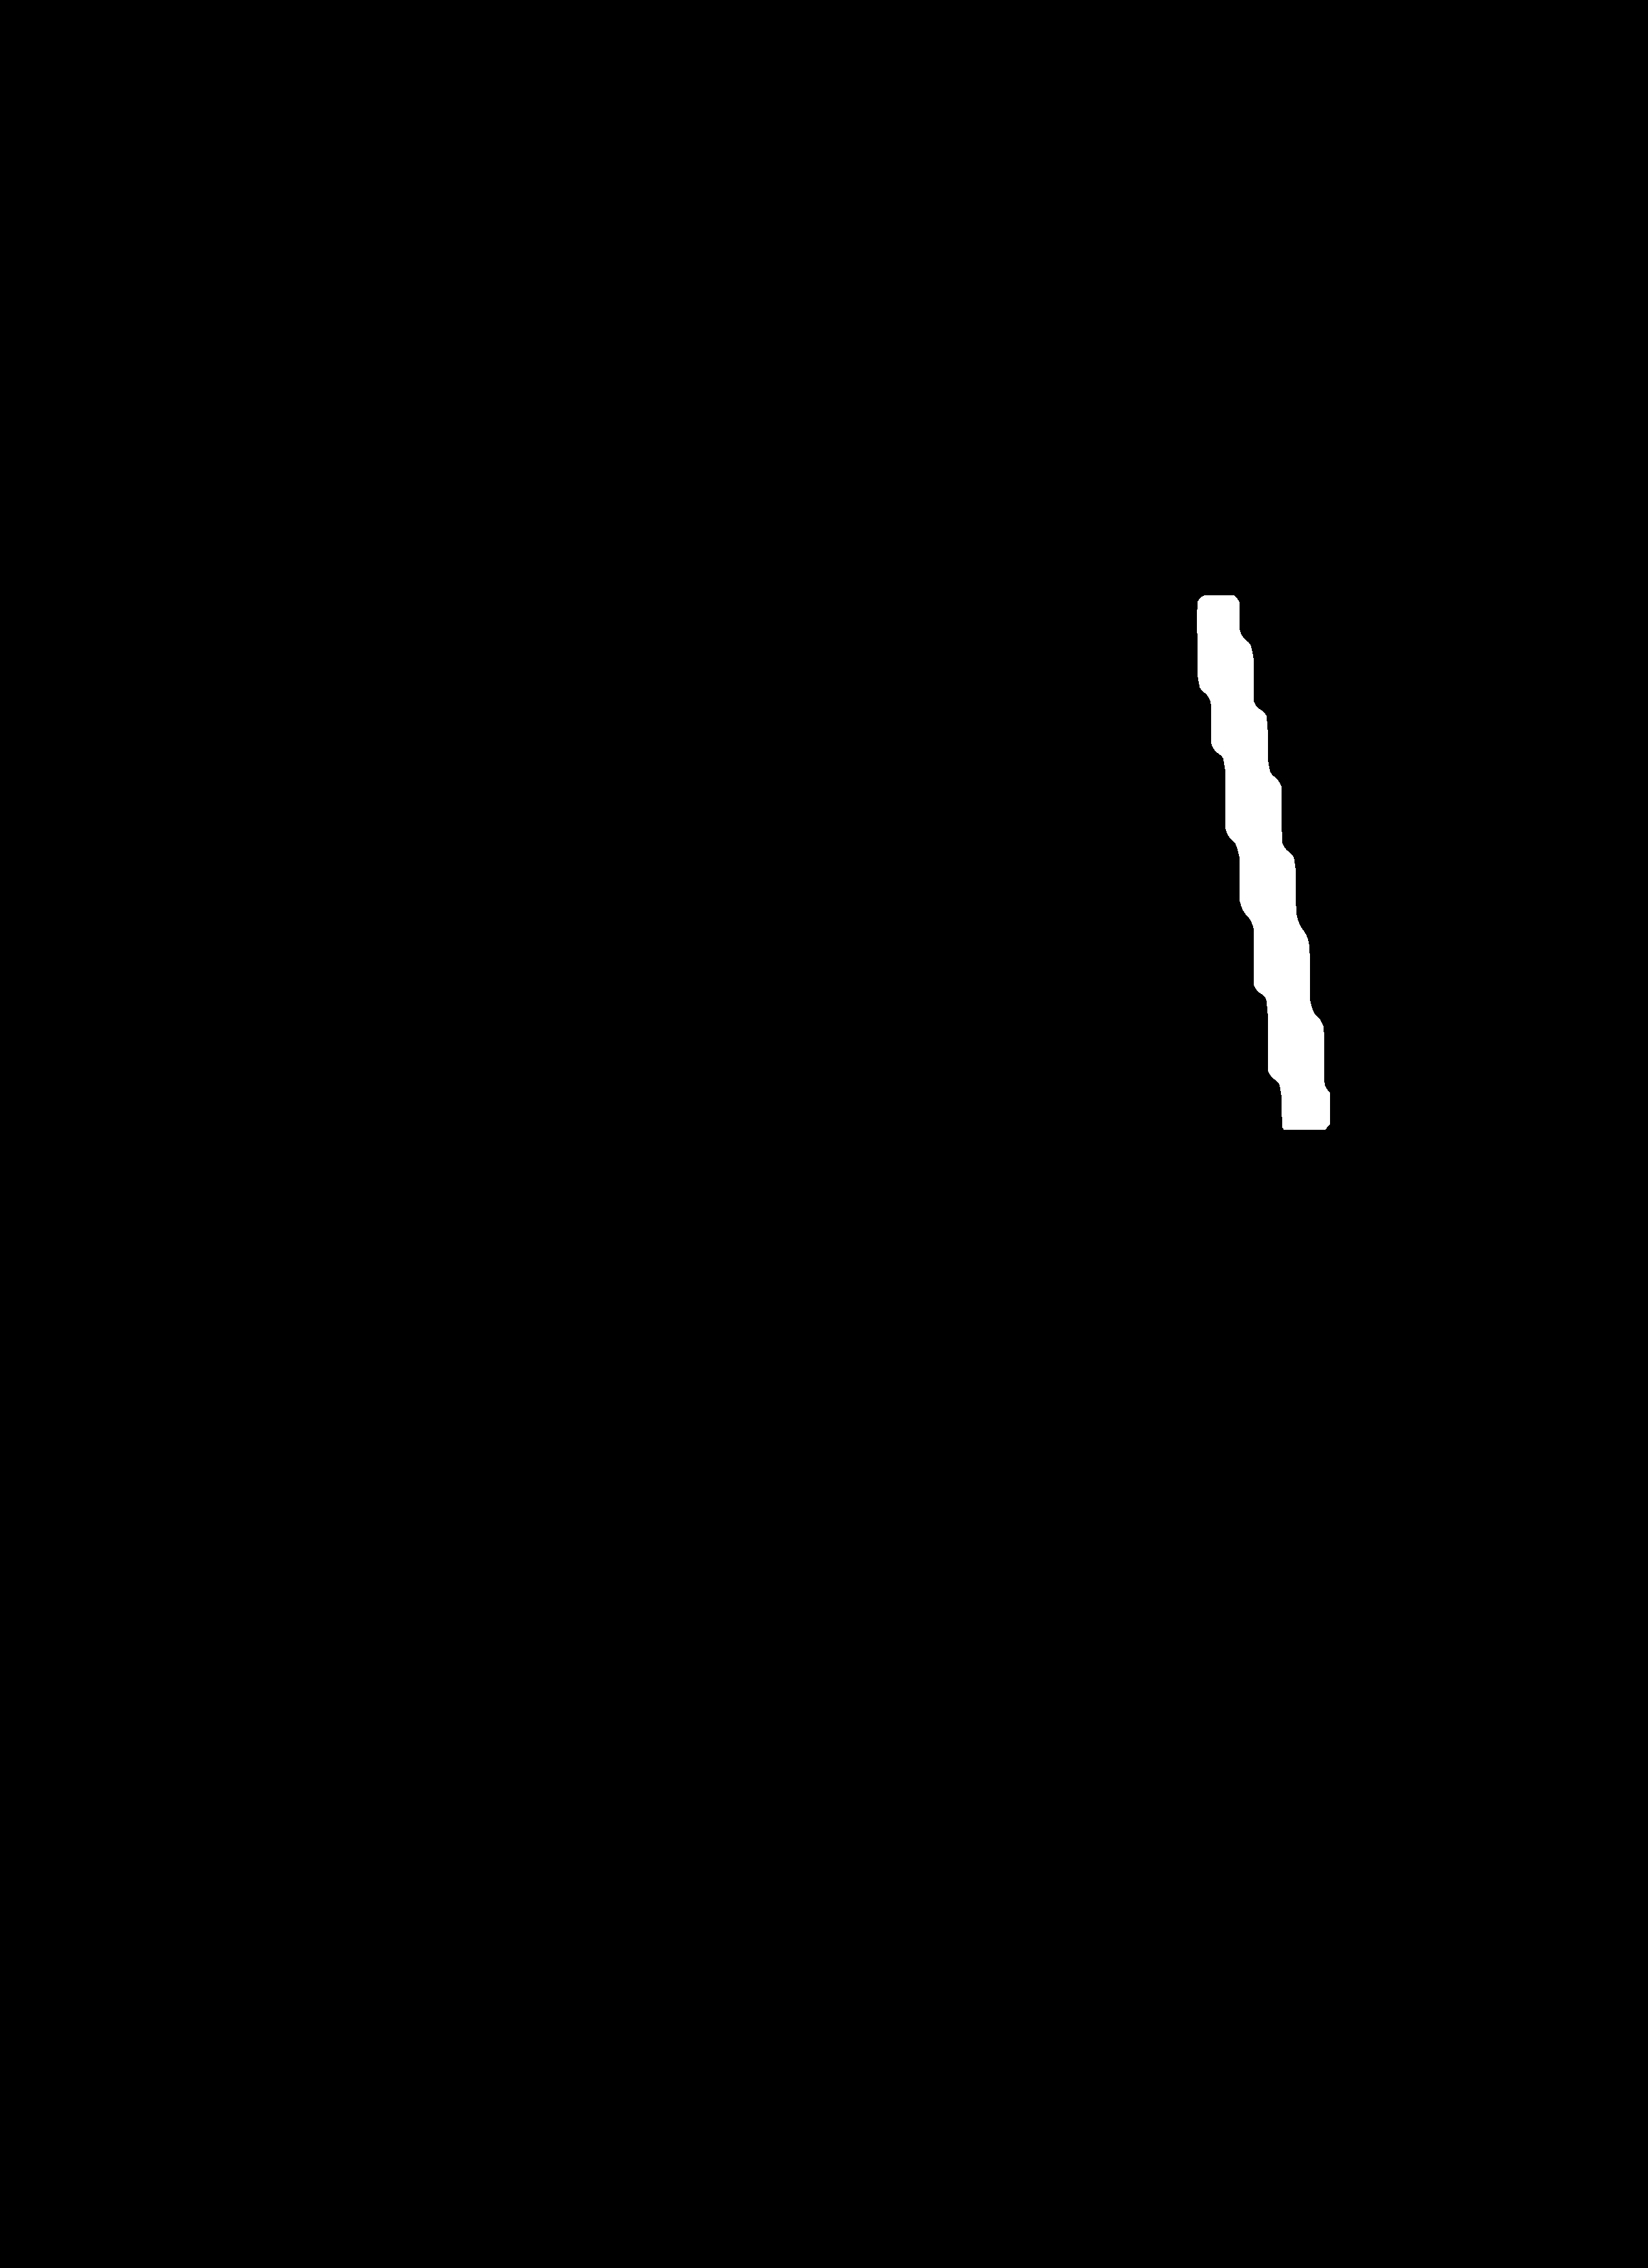
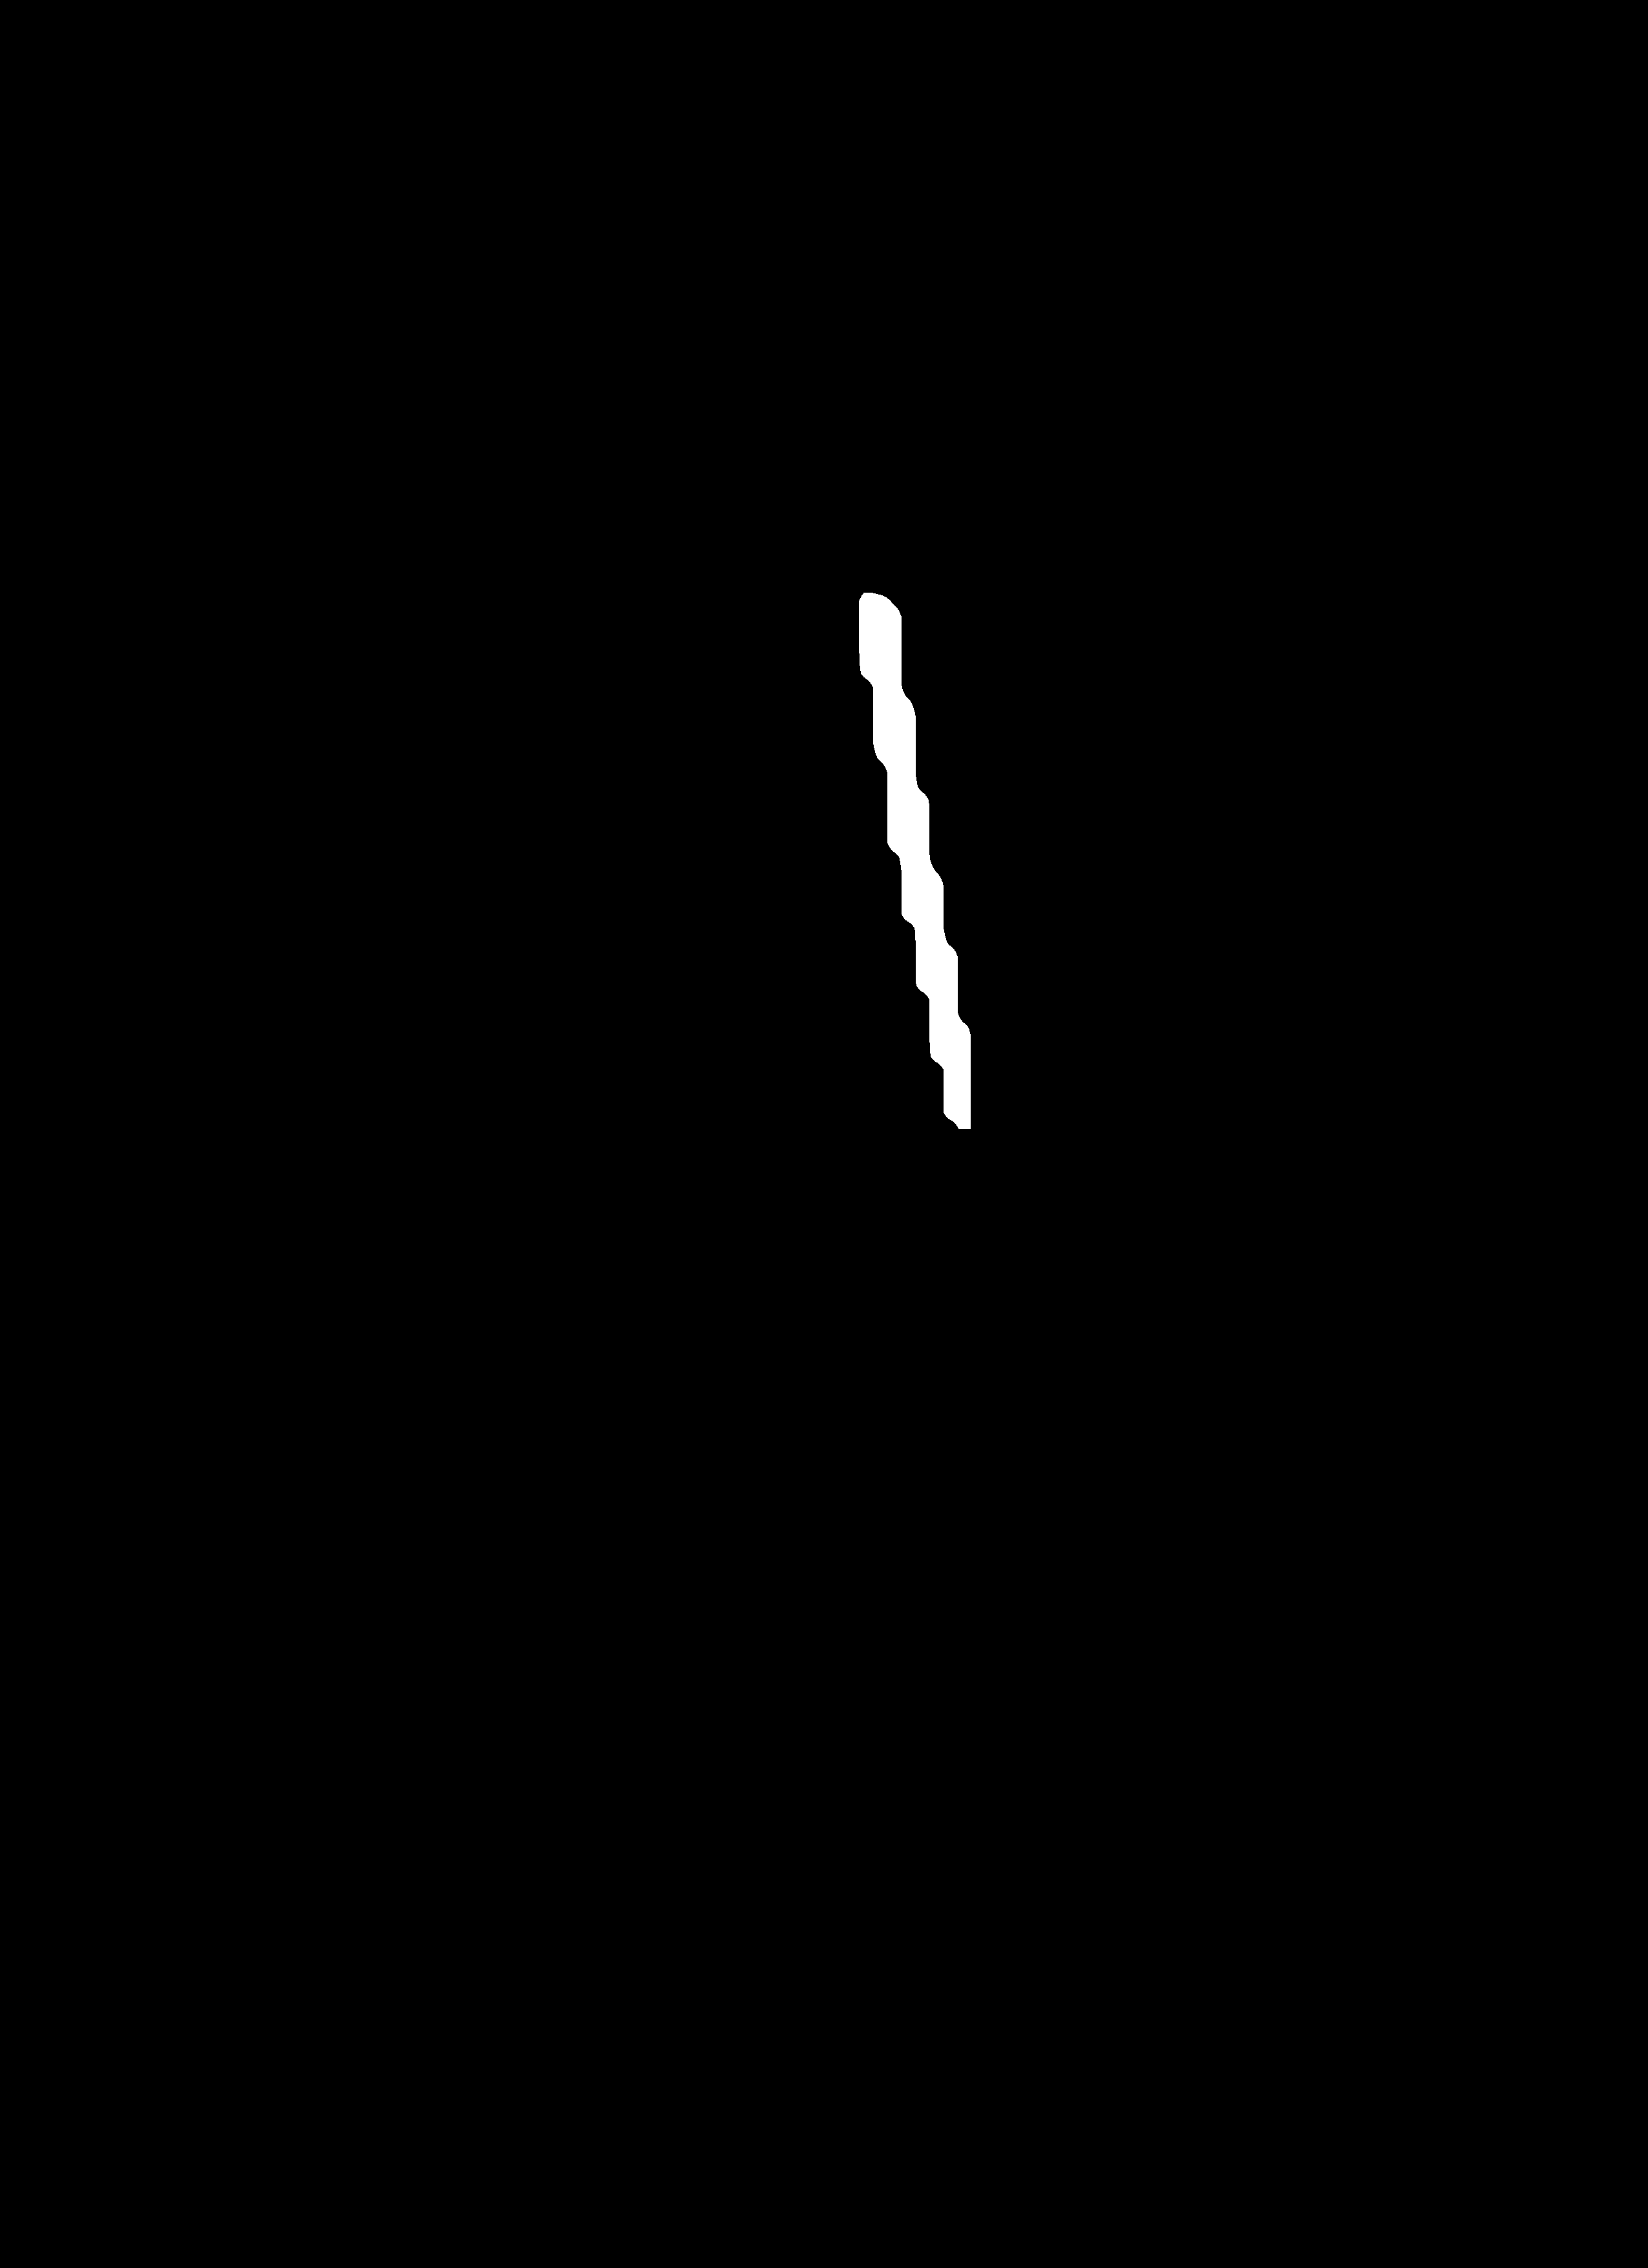
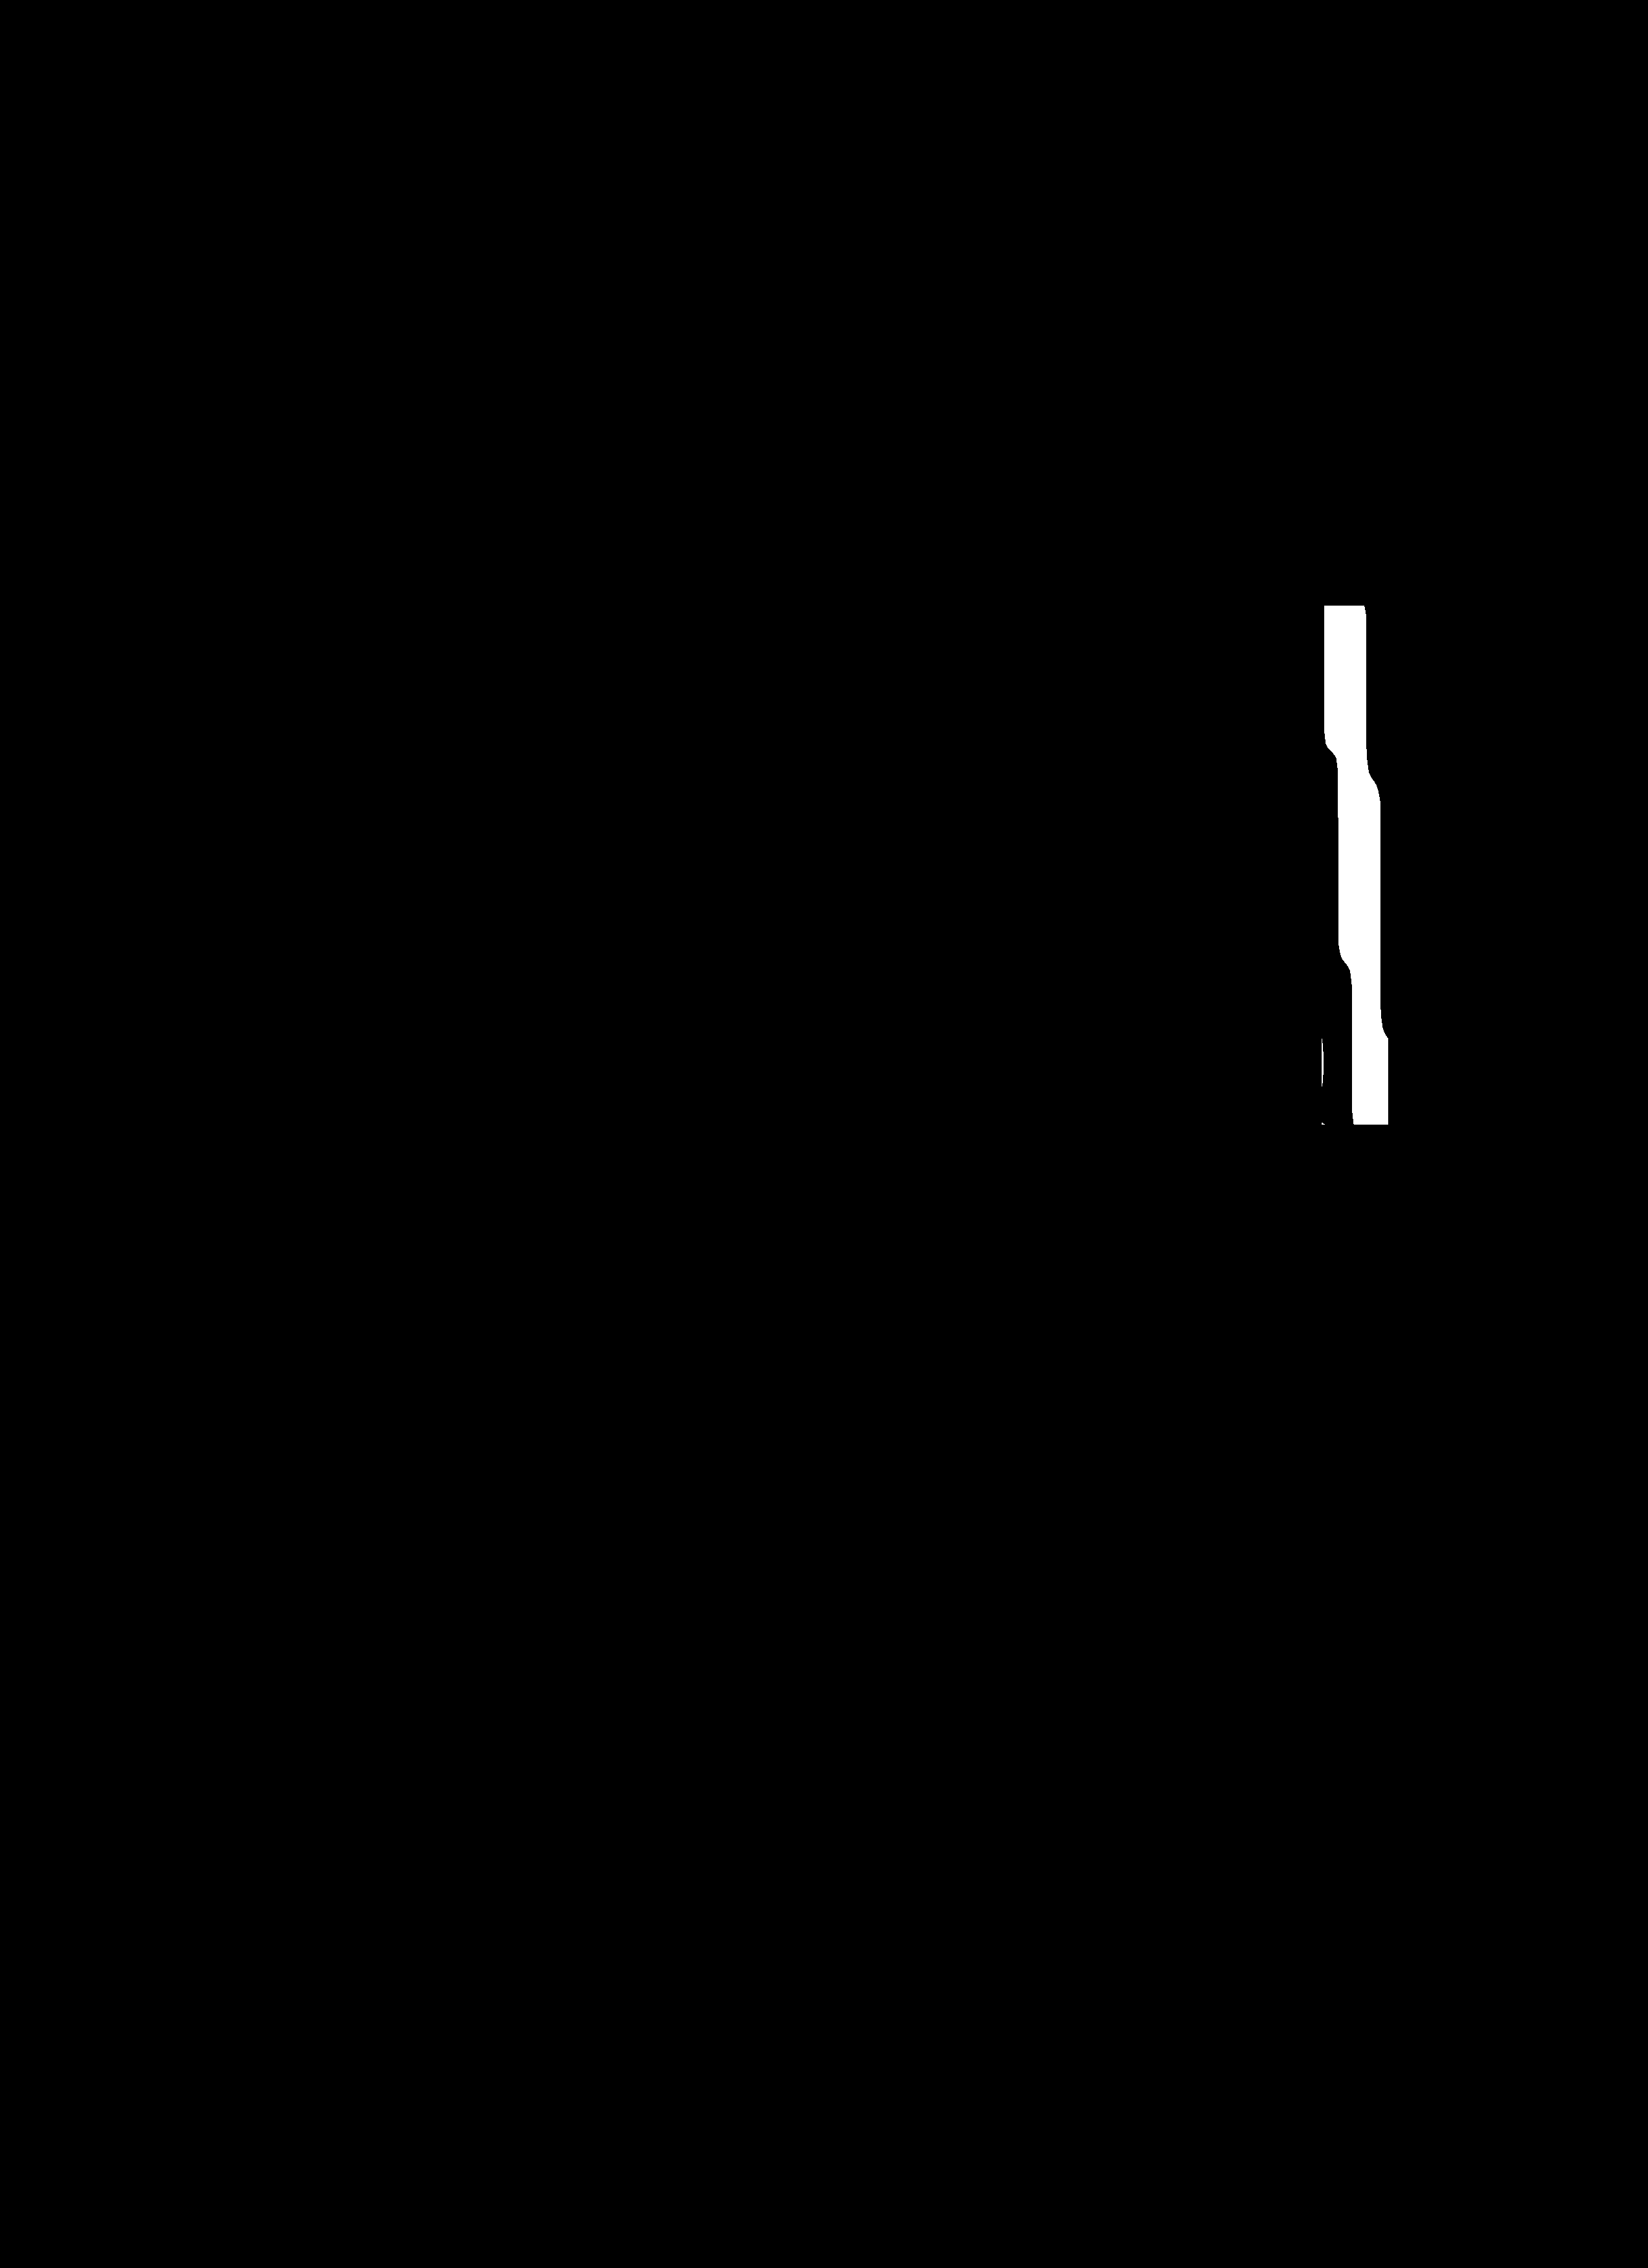
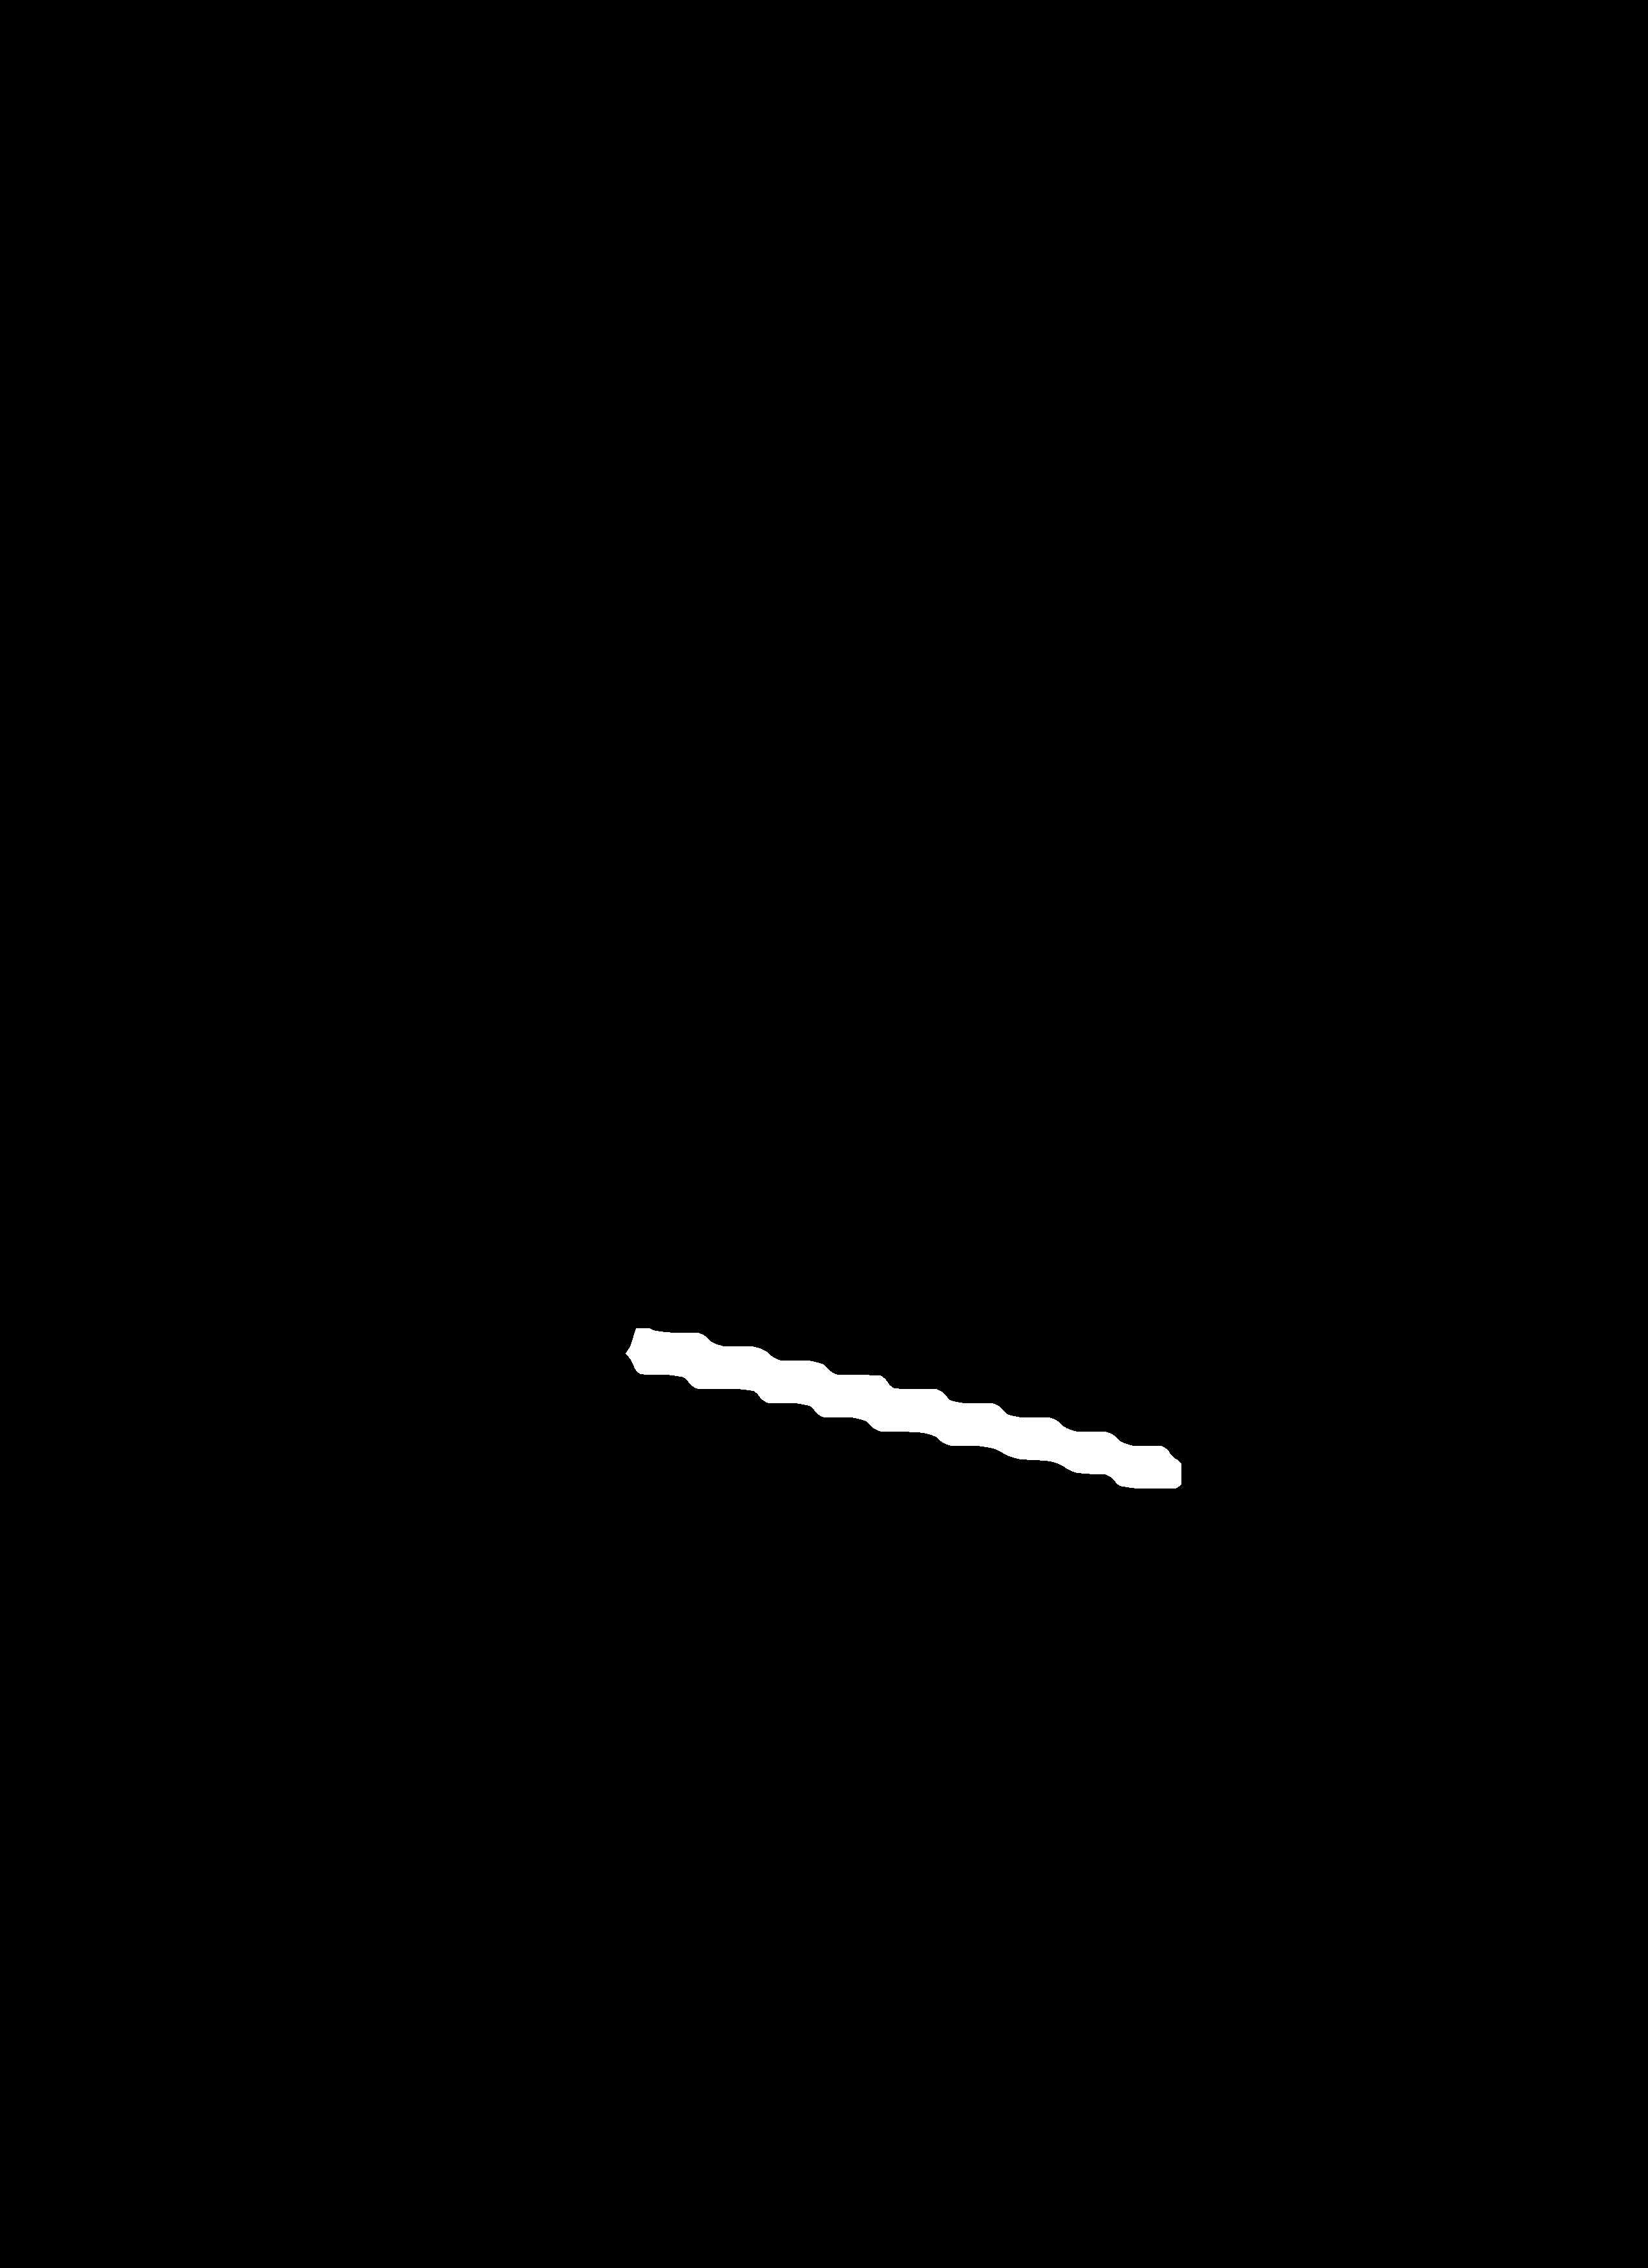

Number of white pixels: 390374
Area 27.983743315555557 cm2


True

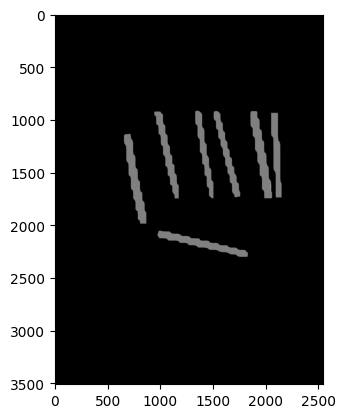

In [ ]:
#main
#upload pretrained weights if available and replace path
model = YOLO('/content/drive/MyDrive/Computational imaging/best-yolov8l-seg.pt')
#model = YOLO('/content/runs/segment/train/weights/best.pt')

import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

#random_file = random.choice(os.listdir("/content/drive/MyDrive/Computational imaging/jpeg_images"))
file_name = "/content/drive/MyDrive/Computational imaging/jpeg_images/AMF007.jpg"


#get parameters of the image
img = cv2.imread(file_name)
height, width, _ = img.shape

#predict segmentation mask, predict only for leaves, class 0 control square, class 1 leaf
results = model(file_name, classes = [1], retina_masks = True)
mask_img = np.zeros((height,width), np.float32) #create empty mask_img
mask_img_list = list()
i=0

for result in results:
  #save the predicted image
  result.save(filename=f'/content/results{i}.jpg', masks=True,labels=False, boxes=False)
  i+=1
  for mask in result.masks.data:
    #save the mask separately
    mask = mask.cpu().numpy() * 255
    mask = cv2.resize(mask, (width,height))
    mask_img += mask
    mask_img_list.append(mask)

!pip install ipyplot
import ipyplot
ipyplot.plot_images(mask_img_list)

#get the pixel count and area
white_pixel_count = np.count_nonzero(mask_img)
img_area=((width*2.54)/300)*((height*2.54)/300) #cm2, image DPI 300 and 2,54 cm
one_pixel_area=img_area/(width*height) #cm2
print(f"Number of white pixels: {white_pixel_count}")
print(f"Area {white_pixel_count*one_pixel_area} cm2")

plt.imshow(mask_img, cmap = 'gray')
cv2.imwrite('./mask.jpg', mask_img)


In [ ]:
#for working on a directory
model = YOLO('/content/drive/MyDrive/Computational imaging/best-yolov8l-seg.pt')

import os
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import csv

#list all files
path = "/content/drive/MyDrive/Computational imaging/jpeg_images/"
files = os.listdir("/content/drive/MyDrive/Computational imaging/jpeg_images/")
mask_img = np.zeros((height,width), np.float32) #create empty mask_img
results_dict = {}

for name in files:
  file_name = path+name
  img = cv2.imread(file_name)
  height, width, _ = img.shape #can be put outside of loop if images are all the same size
  results = model(file_name, classes = [1], retina_masks = True)
  for result in results:
  #save the predicted image
    result.save(filename=f'/content/results1/results_{name}', masks=True,labels=False, boxes=False)
  for mask in result.masks.data:
    mask = mask.cpu().numpy() * 255
    mask = cv2.resize(mask, (width,height))
    mask_img += mask
    cv2.imwrite(f'./results1/mask_{name}', mask_img)
  white_pixel_count = np.count_nonzero(mask_img)
  img_area=((width*2.54)/300)*((height*2.54)/300) #cm2, image DPI 300 and 2,54 cm
  one_pixel_area=img_area/(width*height) #cm2
  results_dict[name] = one_pixel_area*white_pixel_count
  mask_img = np.zeros((height,width), np.float32)

import pandas as pd
!touch /content/dict_file.csv
(pd.DataFrame.from_dict(data=results_dict, orient='index')
   .to_csv('/content/dict_file.csv', header=False))





image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF098.jpg: 640x480 9 leafs, 57.3ms
Speed: 3.1ms preprocess, 57.3ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF095.jpg: 640x480 10 leafs, 54.2ms
Speed: 3.1ms preprocess, 54.2ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF099.jpg: 640x480 9 leafs, 57.8ms
Speed: 3.0ms preprocess, 57.8ms inference, 14.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF094.jpg: 640x480 8 leafs, 57.8ms
Speed: 3.2ms preprocess, 57.8ms inference, 13.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/drive/MyDrive/Computational imaging/jpeg_images/AMF102.jpg: 640x480 8 leafs, 58.2ms
Speed: 4.1ms preprocess, 58.2ms inference, 13.8ms postprocess per image at shape (1, 3,

In [ ]:
!zip -r /content/results_zip.zip /content/results

updating: content/results/ (stored 0%)
updating: content/results/mask_AMF120.jpg.jpg (deflated 49%)
updating: content/results/mask_AMF084.jpg.jpg (deflated 53%)
updating: content/results/mask_AMF001.jpg.jpg (deflated 49%)
updating: content/results/results_AMF110.jpg.jpg (deflated 8%)
updating: content/results/mask_AMF049.jpg.jpg (deflated 52%)
updating: content/results/results_AMF011.jpg.jpg (deflated 8%)
updating: content/results/mask_AMF022.jpg.jpg (deflated 51%)
updating: content/results/results_AMF129.jpg.jpg (deflated 8%)
updating: content/results/mask_AMF012.jpg.jpg (deflated 52%)
updating: content/results/mask_AMF061.jpg.jpg (deflated 53%)
updating: content/results/results_AMF032.jpg.jpg (deflated 8%)
updating: content/results/results_AMF134.jpg.jpg (deflated 9%)
updating: content/results/mask_AMF099.jpg.jpg (deflated 49%)
updating: content/results/mask_AMF050.jpg.jpg (deflated 51%)
updating: content/results/results_AMF028.jpg.jpg (deflated 8%)
updating: content/results/results_

In [ ]:
#yolov8 oriented bounding box dataset
from roboflow import Roboflow
rf = Roboflow(api_key="V63SFc2oAj7ZwbYLIgox")
project = rf.workspace("leafareaproject").project("leaf-area2")
version = project.version(1)
dataset = version.download("yolov8-obb")


ModuleNotFoundError: No module named 'roboflow'

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np
import cv2
from ultralytics import YOLO
#testing differents head configuration
model = YOLO('/content/best-yolov8s.pt')

def yolo_to_mask(yolo_coordinates, image_shape):
    # Create an empty mask
    mask = np.zeros(image_shape)

    # Convert YOLO coordinates to pixel coordinates and draw the polygons on the mask
    for coordinates in yolo_coordinates:
        class_id, *coords = map(float, coordinates)
        coords = np.array(coords).reshape(-1, 2)  # Reshape to Nx2 array
        coords *= np.array(image_shape)  # Scale by image size
        coords = coords.astype(int)  # Convert to integers

        # Draw the polygon on the mask
        cv2.fillPoly(mask, [coords], 1)

    return mask

def read_coordinates_from_txt(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Split each line into coordinates and convert them to floats
    coordinates = [list(map(float, line.split())) for line in lines]
    return coordinates


# Define the transform for the images
image_transform = Compose([  # Resize to nearest dimensions divisible by 32
    ToTensor()
])

# Define the transform for the masks
mask_transform = ToTensor()

class CustomDataset(Dataset):

    def __init__(self, image_dir, label_dir, image_transform=None, mask_transform=None):
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.label_paths = [os.path.join(label_dir, os.path.splitext(img)[0] + '.txt') for img in os.listdir(image_dir)]
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if image.mode != 'RGB':
            image = image.convert('RGB')
        yolo_coordinates = read_coordinates_from_txt(self.label_paths[idx])
        mask = yolo_to_mask(yolo_coordinates, image.size)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Apply the transform when creating your dataset
dataset = CustomDataset('/content/train_img2', '/content/train_label2', image_transform=image_transform, mask_transform=mask_transform)


In [ ]:
import torch.nn as nn

class ModifiedYOLOv8(nn.Module):
    def __init__(self, yolo_v8):
        super(ModifiedYOLOv8, self).__init__()
        self.yolo_v8 = yolo_v8
        self.segmentation_head = nn.Conv2d(yolo_v8.output_channels, 2, kernel_size=1)
        self.regression_head = nn.Linear(yolo_v8.output_channels, 1)

    def forward(self, x):
        yolo_output = self.yolo_v8(x)
        segmentation_output = self.segmentation_head(yolo_output)
        area_output = self.regression_head(yolo_output.view(yolo_output.size(0), -1))
        return yolo_output, segmentation_output, area_output

##main
import pandas as pd
df = pd.read_csv('/content/Leaf scan anaylsis AMF experiment.csv')
print(df.head())
model = ModifiedYOLOv8(yolov8='yolov8s.pt')
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

from torch.utils.data import DataLoader
import torch.nn as nn
# Assuming that `dataset` is your CustomDataset instance
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentation_loss = nn.CrossEntropyLoss()
for epoch in range(100):
    for i, (inputs, masks) in enumerate(train_loader):
        # Move data to the correct device
        inputs = inputs.to(device)
        masks = masks.to(device)

        # Compute the forward pass
        mask_preds, area_preds = model(inputs)

        # Compute the ground truth areas
        areas = masks.sum(dim=[1, 2, 3])  # Sum over the height, width, and channel dimensions

        # Compute the loss
        mask_loss = segmentation_loss(mask_preds, masks)  # Assuming you have defined segmentation_loss
        area_loss = loss_fn(area_preds, areas)
        loss = mask_loss + area_loss

        # Perform backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()


In [ ]:
class ModifiedYOLOv8(torch.nn.Module):
    def __init__(self):
        super(ModifiedYOLOv8, self).__init__()
        self.yolov8 = YOLO('/content/best-yolov8s.pt')  # The original YOLOv8 model
        self.area_estimation_head = AreaEstimationHead()

    def forward(self, x):
        mask = self.yolov8(x)
        area = self.area_estimation_head(mask)
        return mask, area

In [ ]:
class AreaEstimationHead(torch.nn.Module):
    def __init__(self, dpi=300):
        super(AreaEstimationHead, self).__init__()
        self.dpi = dpi

        mask_img = mask.numpy() > 0.5

        # Count the number of white pixels
        white_pixel_count = np.count_nonzero(mask_img)

        # Compute the area of one pixel
        height, width = mask_img.shape[-2:]
        img_area = ((width * 2.54) / self.dpi) * ((height * 2.54) / self.dpi)  # cm²
        one_pixel_area = img_area / (width * height)

        # Compute the area of the mask
        mask_area = white_pixel_count * one_pixel_area

        return torch.tensor(mask_area, device=mask.device)